<a href="https://colab.research.google.com/github/saritmaitra/Natural-Gas_Paul/blob/master/Sarit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data mining approach**


## **Data ingestion, processing, feature engineering and machine learning**

In [1]:
!pip install pyforest
from pyforest import *
import datetime, pickle, copy
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import matplotlib.pyplot as plt
%matplotlib inline  
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
!pip install quandl
import quandl
plt.style.use('ggplot')
from statistics import variance 
from random import randint
import scipy as sp
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, roc_auc_score, mean_squared_error
from xgboost import XGBClassifier, plot_importance
!pip install fredapi
from fredapi import Fred
!pip install EIA_python
import eia
from sklearn.model_selection import cross_val_score, KFold, cross_validate, train_test_split, TimeSeriesSplit
from xgboost import XGBRegressor
import xgboost as xgb
!pip install ffn
import ffn

  Created wheel for pyforest: filename=pyforest-1.0.3-py2.py3-none-any.whl size=13715 sha256=41352f2a8398c8cd24e9aea90626e0f582d206d514ed3046bd1833106a4225fe
  Stored in directory: /root/.cache/pip/wheels/af/0b/39/340a7f15fc8d4ff5ab50847b28789afea04452a9d51b9721b5
Successfully built pyforest


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  Created wheel for ffn: filename=ffn-0.3.4-cp36-none-any.whl size=22814 sha256=fd437049c1f0fe777fc20a8e1b9c70d98e2def63e6ff10c0a8b9ca659fed3317
  Stored in directory: /root/.cache/pip/wheels/20/08/4d/921180e81279d147cb6399fe1e194f2c67a796df86f9f4c5fe
Successfully built ffn


/usr/local/lib/python3.6/dist-packages/ffn/core.py:27: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)
/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## **Current Spot price ($/Mbtu)**


In [0]:
# Henry Hub Spot Price, Daily (Release Date: 3/11/2020; Next Release Date: 3/18/2020 )
print('\033[4mHenry Hub Natural Gas Spot Price, Daily (Dollars per Million Btu)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    hh_spot = pd.DataFrame(series_search)
    return hh_spot

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.RNGWHHD.W'
      hh_spot = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(hh_spot))
      return hh_spot;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

hh_spot = main()
hh_spot = hh_spot.rename({'Henry Hub Natural Gas Spot Price, Weekly (Dollars per Million Btu)': 'hh_spot'}, axis = 'columns')
hh_spot = hh_spot.reset_index()
hh_spot['index'] = pd.to_datetime(hh_spot['index'].str[:-3], format='%Y %m%d')
hh_spot['Date']= pd.to_datetime(hh_spot['index']) 
hh_spot.set_index('Date', inplace=True) # setting index column
hh_spot = hh_spot.loc['2000-01-01':,['hh_spot']] # setting date range
hh_spot = hh_spot.astype(float)
#print(hh_spot) 
print('\n')


Henry Hub Natural Gas Spot Price, Daily (Dollars per Million Btu)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [0]:
hh_spot

,hh_spot
Date,
2000-01-07,2.18
2000-01-14,2.25
2000-01-21,2.46
2000-01-28,2.71
2000-02-04,2.81
...,...
2020-03-20,1.82
2020-03-27,1.74
2020-04-03,1.63


### ***Visualization***

In [0]:
import plotly.express as px
figures = px.line(x=hh_spot.index, y=hh_spot['hh_spot'], labels={'x':'Date', 'y':'Spot Price'})
figures.show()

## **Natural Gas Continuius Contract**

In [2]:
# Natural Gas continuous contract
print('\033[4mNatural Gas continuous contract 1\033[0m')
NG = quandl.get("CHRIS/CME_NG1", authtoken="LSQpgUzwJRoF667ZpzyL") # natural gas continuous contract 1
NG = NG.loc['2000-01-01':,]

Natural Gas continuous contract 1


### ***Current price & visualization***

In [0]:
# new code
print('\033[4mCurrent spot price\033[0m')
print(round(hh_spot,2).tail(1))
print('\n')
print('\033[4mOpen price\033[0m')
print(round(NG['Open'],2).tail(1))
print('\n')
print('\033[4mClose price\033[0m')
print(round(NG['Last'],2).tail(1))
print('\n')
print('\033[4mAdj Close price\033[0m')
print(round(NG['Settle'],2).tail(1))
print('\n')
print('\033[4mHigh price\033[0m')
print(round(NG['High'],2).tail(1))
print('\n')
print('\033[4mLow price\033[0m')
print(round(NG['Low'],2).tail(1))
print('\n')
print('\033[4mVolume\033[0m')
print(round(NG['Volume'],2).tail(1))
print('\n')

import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=NG.index,
                                     open=NG['Open'],
                                     high=NG['High'],
                                     low=NG['Low'],
                                     close=NG['Last'])])
fig.show()
print('\n')

# 4 WEEKS's OPEN AND CLOSE PRICE
ng = round(NG[['Open', 'Last', 'High', 'Low']],2).copy()
ng = ng.reset_index()
ng.tail(20)

Current spot price
            hh_spot
Date               
2020-04-17     1.72


Open price
Date
2020-04-23    1.91
Name: Open, dtype: float64


Close price
Date
2020-04-23    1.82
Name: Last, dtype: float64


Adj Close price
Date
2020-04-23    1.82
Name: Settle, dtype: float64


High price
Date
2020-04-23    1.95
Name: High, dtype: float64


Low price
Date
2020-04-23    1.81
Name: Low, dtype: float64


Volume
Date
2020-04-23    90375.0
Name: Volume, dtype: float64




,Date,Open,Last,High,Low
5071,2020-03-26,1.66,1.64,1.68,1.61
5072,2020-03-27,1.64,1.62,1.65,1.60
5073,2020-03-30,1.63,1.70,1.71,1.61
5074,2020-03-31,1.70,1.64,1.73,1.64
5075,2020-04-01,1.64,1.59,1.68,1.58
5076,2020-04-02,1.59,1.55,1.62,1.52
5077,2020-04-03,1.55,1.66,1.66,1.53
5078,2020-04-06,1.65,1.75,1.76,1.63
5079,2020-04-07,1.76,1.91,1.91,1.75
5080,2020-04-08,1.90,1.79,1.92,1.77


In [0]:
NG.columns

Index(['Open', 'High', 'Low', 'Last', 'Change', 'Settle', 'Volume', 'Previous Day Open Interest'], dtype='object')

### ***Historical daily prices of the previous indices***
- Date : in days
- Open : price of the stock at the opening of the trading (in US dollars)
- High : highest price of the stock during the trading day (in US dollars)
- Low : lowest price of the stock during the trading day (in US dollars)
- Last/Close : price of the stock at the closing of the trading (in US dollars)
- Volume : amount of stocks traded (in US dollars)
- Settle/Adj Close : price of the stock at the closing of the trading adjusted with dividends (in US dollars)

### ***Statistics 1***

In [0]:
perf = NG['Last'].copy().calc_stats()
print('\n')
perf.display()
print('\n')



Stats for Last from 2000-01-04 00:00:00 - 2020-04-20 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
-10.94%             0.26  -0.57%  -89.91%

Annualized Returns:
mtd     3m      6m       ytd      1y       3y       5y      10y     incep.
------  ------  -------  -------  -------  -------  ------  ------  --------
17.95%  -3.25%  -17.85%  -11.22%  -22.26%  -15.11%  -5.23%  -6.93%  -0.57%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.26     0.23       0.02
mean    14.78%   12.20%     0.77%
vol     56.11%   53.50%     41.62%
skew    1.52     0.69       0.62
kurt    22.33    1.96       0.14
best    58.02%   62.61%     86.34%
worst   -32.80%  -41.62%    -73.71%

Drawdowns:
max      avg       # days
-------  ------  --------
-89.91%  -9.89%    187.31

Misc:
---------------  -------
avg. up month    11.90%
avg. down month  -10.33%
up year 

In [0]:
p = pd.DataFrame(perf.display())
p

<IPython.core.display.Javascript object>

Stats for Last from 2000-01-04 00:00:00 - 2020-04-03 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
-23.76%             0.25  -1.33%  -89.91%

Annualized Returns:
mtd    3m       6m       ytd      1y       3y       5y      10y     incep.
-----  -------  -------  -------  -------  -------  ------  ------  --------
0.97%  -21.52%  -29.04%  -24.00%  -37.98%  -19.21%  -8.95%  -9.04%  -1.33%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.25     0.21       0.00
mean    13.96%   11.37%     0.13%
vol     56.01%   53.36%     41.91%
skew    1.53     0.70       0.65
kurt    22.54    2.02       0.09
best    58.02%   62.61%     86.34%
worst   -32.80%  -41.62%    -73.71%

Drawdowns:
max      avg       # days
-------  ------  --------
-89.91%  -9.89%    186.87

Misc:
---------------  -------
avg. up month    11.77%
avg. down month  -10.33%
up year % 

""


In [0]:
#print('\033[4mMonthly returns\033[0m')
#print(perf.display_monthly_returns())
#perf.display_monthly_returns()
#print('\n')



Statistics
start                    2000-01-04 00:00:00
end                      2020-04-08 00:00:00
rf                                         0
total_return                       -0.176011
cagr                             -0.00951013
max_drawdown                       -0.899142
calmar                            -0.0105769
mtd                                0.0912964
three_month                        -0.166434
six_month                          -0.216689
ytd                                -0.178653
one_year                           -0.338376
three_year                         -0.179424
five_year                         -0.0729515
ten_year                          -0.0749694
incep                            -0.00951013
daily_sharpe                        0.256367
daily_sortino                       0.467256
daily_mean                          0.143709
daily_vol                            0.56056
daily_skew                           1.52225
daily_kurt                           22.44

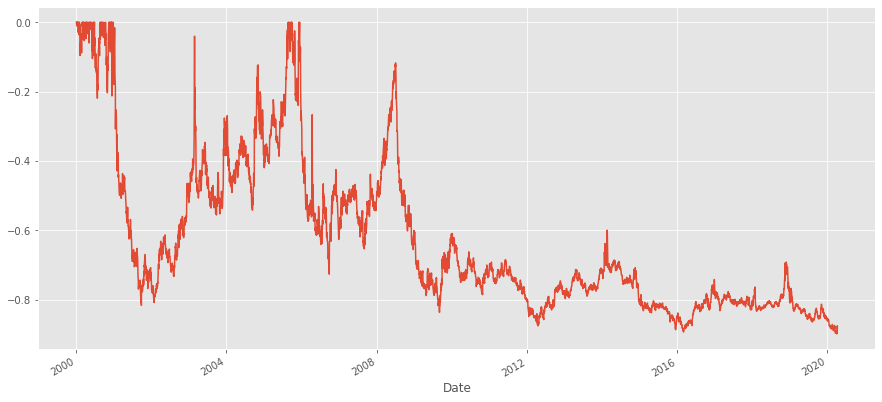

In [0]:
%matplotlib inline 

ffn.to_drawdown_series(NG['Last']).plot(figsize=(15,7),grid=True)
print('\n')

print('\033[4mStatistics\033[0m')
print(perf.stats)
print('\n')


### ***Statistics 2***

In [0]:
# Calculate the daily percentage change which is daily return
#print('\033[1m' + 'daily percentage change' + '\033[1m')
daily_ret = NG['Last'].pct_change().fillna(0)
mean_return = daily_ret.mean()
return_stdev = daily_ret.std()
print('Average daily return %:', round((mean_return*100),2))
print('Average Volatility %:', round((return_stdev*100), 2))

Average daily return %: 0.06
Average Volatility %: 3.53


In [0]:
print ('Annualized average return %:', round(((mean_return * 252)*100),2))
print('Annualized volatility %:', round(((return_stdev * np.sqrt(252))*100), 2))


Annualized average return %: 14.78


<IPython.core.display.Javascript object>

Annualized volatility %: 56.1


<IPython.core.display.Javascript object>

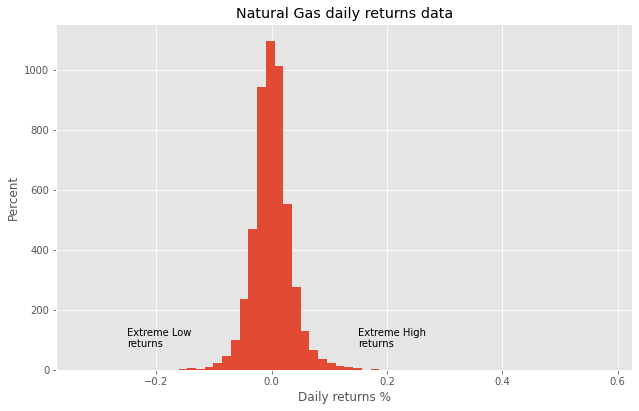



Maximum Drawdown
Maximum Daily Drawdown
Date
2000-01-04    0.000000
2000-01-05   -0.003676
2000-01-06    0.000000
2000-01-07   -0.010474
2000-01-10    0.000000
                ...   
2020-04-02   -0.459016
2020-04-03   -0.421346
2020-04-06   -0.389955
2020-04-07   -0.334496
2020-04-08   -0.374608
Name: Last, Length: 5081, dtype: float64


Min Daily Drawdown
Date
2000-01-04    0.000000
2000-01-05   -0.003676
2000-01-06   -0.003676
2000-01-07   -0.010474
2000-01-10   -0.010474
                ...   
2020-04-02   -0.559705
2020-04-03   -0.559705
2020-04-06   -0.559705
2020-04-07   -0.559705
2020-04-08   -0.559705
Name: Last, Length: 5081, dtype: float64




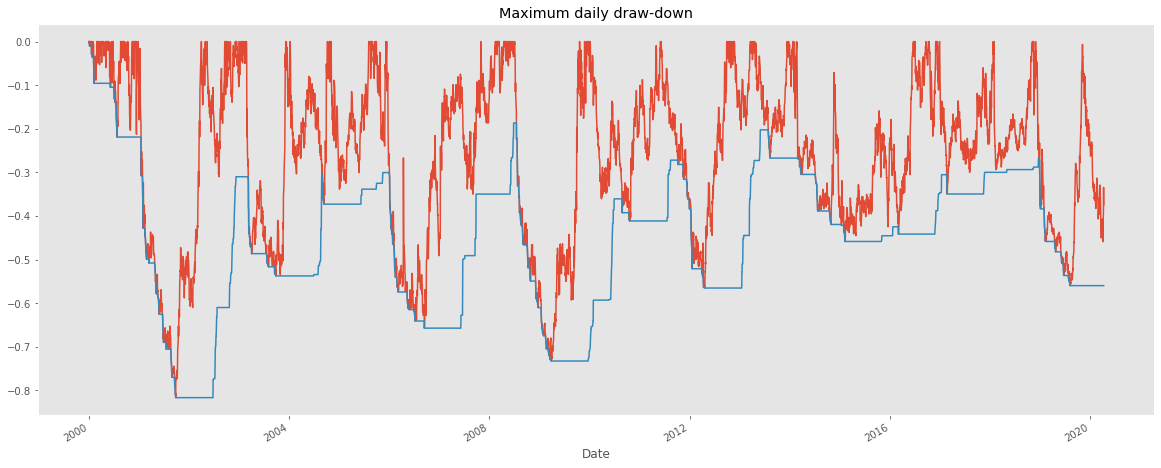

In [0]:
#print('\033[4mStatistics summary\033[0m')
#print(merge12.daily_ret.describe())
#print('\n')

#print('\033[4mCritical Values\033[0m')
n = len(daily_ret)
test_statistic = ((daily_ret.mean() - 0) / (daily_ret.std()/np.sqrt(n)))
#print ('t test statistic: ', test_statistic)
#print('\n')

from scipy.stats import t
p_val = 2 * (1 - t.cdf(test_statistic, n - 1))
#print ('P-value is: ', p_val)
#print('\n')

from scipy.stats import chi2
# Here we calculate the critical value directly because our df is too high for most chisquare tables
crit_value = chi2.ppf(0.99, (n - 1))
#print ('Critical value at α = 0.01 with 251 df: ', crit_value)
#print('\n')

# +/- %5 daily change distribution in Henry Hub gas prices
#daily_ret.hist(bins=100, range = (-0.05, 0.05), figsize = (15,8))
#plt.title('+/- 5% daily change distribution in Henry Hub gas prices')
#plt.show()
#print('\n')

# Plot the distributions
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
daily_ret.plot.hist(bins = 60)
ax1.set_xlabel("Daily returns %")
ax1.set_ylabel("Percent")
ax1.set_title("Natural Gas daily returns data")
ax1.text(-0.25,75,"Extreme Low\nreturns")
ax1.text(0.15,75,"Extreme High\nreturns")
plt.show()
print('\n')
#print ('\033[1m' + 'Shapiro test: W-test, and P-value' + '\033[1m')
#print(stats.shapiro(daily_ret))
#print('\n')
#print("Skewness, Kurtosis : ", daily_ret.skew(), daily_ret.kurtosis())
#print('\n')
#print("T-value P-value (two-tail)")
#print(stats.ttest_1samp(daily_ret, 0.5))
#print(stats.ttest_1samp(daily_ret, 0))
#print('\n')

print('\033[4mMaximum Drawdown\033[0m')

# Using a trailing 186 trading day window
window = 186

# Calculate the max drawdown in the past window days for each day in the series.
# using min_periods=1, we want to let the first 186 days data have an expanding window
roll_max = NG['Last'].rolling(min_periods=1, window=window).max()

# Calculate daily draw-down from rolling max
daily_drawdown = NG['Last']/roll_max - 1.0
print('\033[4mMaximum Daily Drawdown\033[0m')
print(daily_drawdown)
print('\n')

# Next we calculate the minimum (negative) daily drawdown in that window.
# using min_periods=1 to allow the expanding window
print('\033[4mMin Daily Drawdown\033[0m')
min_daily_drawdown = daily_drawdown.rolling(min_periods=1, window=window).min()
print(min_daily_drawdown)
print('\n')

# Plot the results
daily_drawdown.plot(figsize=(20,8))
min_daily_drawdown.plot()
#plt.title('Orange -> Daily running 186-day drawdown; Blue -> Max. experienced 186-day drawdown in the past year')
plt.title('Maximum daily draw-down')
plt.grid()
plt.show()
print('\n')

In [0]:
# empirical quantile of daily returns
import scipy.stats
print('\033[4mEmpirical quantile of daily returns\033[0m')
daily_ret.quantile(0.05)

Empirical quantile of daily returns


-0.04965476474311298

The 0.05 (p=0.05) empirical quantile of daily returns is at -0.0496. This means that with 95% confidence, the worst daily loss will not exceed 4.96% (of the investment).

As an example, if we have a USD 1M investment, our one-day 5% VaR is 0.0496 * USD 1M = USD 49.60 k

### ***Sharpe Ratio***
Sharpe Ratio is a measure of risk-adjusted returns.

The Sharpe Ratio is the mean (daily return - the risk free rate) % standard deviation.

This ratio is generally intended to be a yearly measurement, so we're going to multiply this by the square root of 252 to get the annualized Sharpe ratio.

Generally a Sharpe Ratio above 1 is considered acceptable to investors (of course depending on risk-tolerance), a ratio of 2 is very good, and a ratio above 3 is considered to be excellent.

In [0]:
print('\033[4mSharpe of daily return %\033[0m')
sharpe_ratio = daily_ret.mean() / daily_ret.std()
Sharpe = round(sharpe_ratio,2)*100
print('Sharpe Ratio:', Sharpe)
print('\n')

print('\033[4mAverage Annual Sharpe %\033[0m')
Sharpe_an = round(((252**0.5) * sharpe_ratio),2)*100
print('Annualized Sharpe %:', Sharpe_an)

Sharpe of daily return %
Sharpe Ratio: 2.0


Average Annual Sharpe %
Annualized Sharpe %: 26.0


### ***Statistics 3***

In [0]:
print('\033[4mProbability of +/-(1%); +/-(3%); +/-%(5) change in price (Data -> 2000- till date)\033[0m')

print ("The probability of price changes between 1%% and -1%% is %1.2f%% " % 
       (100*daily_ret[(daily_ret > -0.01) & (daily_ret < 0.01)].shape[0] / daily_ret.shape[0]))
print ("The probability of price changes between 3%% and -3%% is %1.2f%% " % 
       (100*daily_ret[(daily_ret > -0.03) & (daily_ret < 0.03)].shape[0] / daily_ret.shape[0]))
print ("The probability of price changes between 5%% and -5%% is %1.2f%% " % 
       (100*daily_ret[(daily_ret > -0.05) & (daily_ret < 0.05)].shape[0] / daily_ret.shape[0]))
print ("The probability of price changes more than 5%% is %1.2f%%" % 
       (100*daily_ret[daily_ret > 0.05].shape[0] / daily_ret.shape[0]))
print ("The probability of price changes less than -5%% is %1.2f%%" % 
       (100*daily_ret[daily_ret < -0.05].shape[0] / daily_ret.shape[0]))
print('\n')

print('\033[4mMinimum price [2000- till date]\033[0m')
print(round(NG['Last'].min(),2), NG['Last'].idxmin());
print('\033[4mMaximum price [2000- till date]\033[0m')
print(round(NG['Last'].max(),2), NG['Last'].idxmax());
print('\n')

print('\033[4mMinimum daily % return [2000- till date]\033[0m')
print(round(daily_ret.min(),2)*100, daily_ret.idxmin()); 
print('\033[4mMaximum daily % return [2000- till date]\033[0m')
print(round(daily_ret.max()*100, 2), daily_ret.idxmax());
print('\n')

Probability of +/-(1%); +/-(3%); +/-%(5) change in price (Data -> 2000- till date)
The probability of price changes between 1% and -1% is 28.38% 
The probability of price changes between 3% and -3% is 71.99% 
The probability of price changes between 5% and -5% is 89.19% 
The probability of price changes more than 5% is 5.99%
The probability of price changes less than -5% is 4.82%


Minimum price [2000- till date]
1.55 2020-04-02 00:00:00
Maximum price [2000- till date]
15.38 2005-12-13 00:00:00


Minimum daily % return [2000- till date]
-33.0 2006-04-17 00:00:00
Maximum daily % return [2000- till date]
58.02 2006-04-14 00:00:00




# **Importing API's**

### Data Pipeline

In [3]:
# Cushing, OK WTI Spot Price FOB, Daily
print('\033[4mWTI Spot Price FOB, Daily (Dollars per Barrel)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    wti = pd.DataFrame(series_search)
    return wti

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='PET.RWTC.D'
      wti = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(wti))
      return wti;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

wti = main()
wti = wti.rename({'Cushing, OK WTI Spot Price FOB, Daily (Dollars per Barrel)': 'wti'}, axis = 'columns')
wti = wti.reset_index()
wti['index'] = pd.to_datetime(wti['index'].str[:-3], format='%Y %m%d')
wti['Date']= pd.to_datetime(wti['index']) 
wti.set_index('Date', inplace=True) # setting index column
wti = wti.loc['2000-01-01':,['wti']] # setting date range
wti = wti.astype(float)
#print(wti) 
#print('\n')

## GDP data
print('\033[4mUS GDP Data\033[0m')
fred = Fred(api_key='59c798fcda5850ef874412d269fd2378')
gdp = fred.get_series_as_of_date('GDP', '2020-01-31')
gdp = gdp.rename({'date': 'Date', 'value': 'gdp'}, axis = 'columns')
gdp.set_index('Date', inplace=True) # setting index column
gdp = gdp.loc['2000-01-01':'2020-02-02',['gdp']] # setting date range
gdp.replace({pd.NaT: "0"}, inplace=True) # replacing NaT with 0
gdp = gdp.ffill().bfill()
gdp = gdp.reset_index().drop_duplicates('Date').set_index('Date') # dropping duplicate concurrence
gdp = pd.DataFrame(gdp)
gdp = gdp.astype(float)
gdp = gdp.resample('B').ffill()
gdp = gdp/4
#print(gdp)
#print('\n')

# U.S. Natural Gas Marketed Production, Monthly
print('\033[4mNatural Gas Marketed Production, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    prod = pd.DataFrame(series_search)
    return prod

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9050US2.M'
      prod = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(prod))
      return prod;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

prod = main()
prod = prod.rename({'U.S. Natural Gas Marketed Production, Monthly (Million Cubic Feet)': 'prod'}, axis = 'columns')
prod = prod.reset_index()
prod['Date']= pd.to_datetime(prod['index']) 
prod.set_index('Date', inplace=True) # setting index column
prod = prod.loc['2000-01-01':,['prod']] # setting date range
prod = prod.astype(float)
prod = prod.resample('B').ffill()
prod = prod/21
#print(prod)
#print('\n')


# U.S. Natural Gas Gross Withdrawals, Monthly
print('\033[4mNatural Gas Gross Withdrawals, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    withdrawals = pd.DataFrame(series_search)
    return withdrawals

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9010US2.M' 
      withdrawals = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(withdrawals))
      return withdrawals;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

withdrawals = main()
withdrawals = withdrawals.rename({'U.S. Natural Gas Gross Withdrawals, Monthly (Million Cubic Feet)': 'withdrawals'}, axis = 'columns')
withdrawals = withdrawals.reset_index()
withdrawals['Date']= pd.to_datetime(withdrawals['index']) 
withdrawals.set_index('Date', inplace=True) # setting index column
withdrawals = withdrawals.loc['2000-01-01':,['withdrawals']] # setting date range
withdrawals = withdrawals.astype(float)
withdrawals = withdrawals.resample('B').bfill().ffill()
withdrawals = withdrawals/21
#print(withdrawals)
#print('\n')

# U.S. Natural Gas Underground Storage Volume, Monthly
print('\033[4mNatural Gas Underground Storage Volume, Monthly\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    storage = pd.DataFrame(series_search)
    return storage

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N5030US2.M '
      storage = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(storage))
      return storage;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

storage = main()
storage = storage.rename({'U.S. Natural Gas Underground Storage Volume, Monthly (Million Cubic Feet)': 'storage'}, axis = 'columns')
storage = storage.reset_index()
storage['Date']= pd.to_datetime(storage['index']) 
storage.set_index('Date', inplace=True) # setting index column
storage = storage.loc['2000-01-01':,['storage']] # setting date range
stoarge = storage.astype(float)
storage = storage.resample('B').bfill().ffill()
storage = storage/21
#print(storage)
#print('\n')

# U.S. Natural Gas Exports, Monthly
print('\033[4mNatural Gas Exports, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    export = pd.DataFrame(series_search)
    return export

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9133US2.M'
      export = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(export))
      return export;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

export = main()
export = export.rename({'Liquefied U.S. Natural Gas Exports, Monthly (Million Cubic Feet)': 'export'}, axis = 'columns')
export = export.reset_index()
export['Date']= pd.to_datetime(export['index']) 
export.set_index('Date', inplace=True) # setting index column
export = export.loc['2000-01-01':,['export']] # setting date range
export = export.astype(float)
export = export.resample('B').bfill().ffill()
export = export/21
#print(export)
#print('\n')

# natural gas total consumption (monthly))
print('\033[4mNatural Gas Total Consumption, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    consumption = pd.DataFrame(series_search)
    return consumption

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9140US2.M'
      consumption = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(consumption))
      return consumption;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

consumption = main()
consumption = consumption.rename({'U.S. Natural Gas Total Consumption, Monthly (Million Cubic Feet)': 'consumption'}, axis = 'columns')
consumption = consumption.reset_index()
consumption['Date']= pd.to_datetime(consumption['index']) 
consumption.set_index('Date', inplace=True) # setting index column
consumption = consumption.loc['2000-01-01':,['consumption']] # setting date range
consumption = consumption.astype(float)
consumption = consumption.resample('B').ffill().bfill()
consumption = consumption/21
#print(consumption)
#print('\n')

# New York Harbor No. 2 Heating Oil Spot Price FOB, Monthly
print('\033[4mHeating Oil Spot Price FOB, Daily (Dollars per Gallon)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    heatingoil = pd.DataFrame(series_search)
    return heatingoil

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='PET.EER_EPD2F_PF4_Y35NY_DPG.D'
      heatingoil = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(heatingoil))
      return heatingoil;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

heatingoil = main()
heatingoil = heatingoil.rename({'New York Harbor No. 2 Heating Oil Spot Price FOB, Daily (Dollars per Gallon)': 'heatingoil'}, axis = 'columns')
heatingoil = heatingoil.reset_index()
heatingoil['index'] = pd.to_datetime(heatingoil['index'].str[:-3], format='%Y %m%d')
heatingoil['Date']= pd.to_datetime(heatingoil['index']) 
heatingoil.set_index('Date', inplace=True) # setting index column
heatingoil = heatingoil.loc['2000-01-01':,['heatingoil']] # setting date range
heatingoil = heatingoil.astype(float)
#print(heatingoil)
#print('\n')

# natural gas import dat
#print('\033[4mNatural Gas Imports, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    g_import = pd.DataFrame(series_search)
    return g_import

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9100US2.M'
      g_import = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(g_import))
      return g_import;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)
  
g_import = main()
g_import = g_import.rename({'U.S. Natural Gas Imports, Monthly (Million Cubic Feet)': 'g_import'}, axis = 'columns')
g_import = g_import.reset_index()
g_import['Date']= pd.to_datetime(g_import['index']) 
g_import.set_index('Date', inplace=True) # setting index column
g_import = g_import.loc['2000-01-01':,['g_import']] # setting date range
g_import = g_import.astype(float)
g_import = g_import.resample('B').ffill().bfill()
g_import = g_import/21
#print(g_import)
#print('\n')

# U.S. Natural Gas Rotary Rigs in Operation, Monthly
print('\033[4mNatural Gas Rotary Rigs in Operation, Monthly (Number of Elements)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    drilling = pd.DataFrame(series_search)
    return drilling

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='PET.E_ERTRRG_XR0_NUS_C.M '
      drilling = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(drilling))
      return drilling;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)
  
drilling = main()
drilling = drilling.rename({'U.S. Natural Gas Rotary Rigs in Operation, Monthly (Number of Elements)': 'drilling'}, axis = 'columns')
drilling = drilling.reset_index()
drilling['Date']= pd.to_datetime(drilling['index']) 
drilling.set_index('Date', inplace=True) # setting index column
drilling = drilling.loc['2000-01-01':,['drilling']] # setting date range
drilling = drilling.astype(float)
drilling = drilling.resample('B').ffill().bfill()
drilling = drilling/21
#print(drilling)
#print('\n')

# Heating Degree Days U.S. Average , Monthly
print('\033[4mHeating Degree Days U.S. Average , Monthly (total degree days)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    HDD_US = pd.DataFrame(series_search)
    return HDD_US

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='STEO.ZWHDPUS.M'
      HDD_US = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(HDD_US))
      return HDD_US;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)
  
HDD_US = main()
HDD_US = HDD_US.rename({'Heating Degree Days U.S. Average , Monthly (total degree days)': 'HDD_US'}, axis = 'columns')
HDD_US = HDD_US.reset_index()
HDD_US['Date']= pd.to_datetime(HDD_US['index']) 
HDD_US.set_index('Date', inplace=True) # setting index column
HDD_US = HDD_US.loc['2000-01-01':,['HDD_US']] # setting date range
HDD_US = HDD_US.astype(float)
HDD_US = HDD_US.resample('B').ffill().bfill()
HDD_US = HDD_US/21
#print(HDD_US)
#print('\n')

# Cooling Degree-Days, United States, Monthly
print('\033[4mCooling Degree-Days, United States, Monthly (Number)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    CDD_US = pd.DataFrame(series_search)
    return CDD_US

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='TOTAL.ZWCDPUS.M'
      CDD_US = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(CDD_US))
      return CDD_US;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)
  
CDD_US = main()
CDD_US = CDD_US.rename({'Cooling Degree-Days, United States, Monthly (Number)': 'CDD_US'}, axis = 'columns')
CDD_US = CDD_US.reset_index()
CDD_US['Date']= pd.to_datetime(CDD_US['index']) 
CDD_US.set_index('Date', inplace=True) # setting index column
CDD_US = CDD_US.loc['2000-01-01':,['CDD_US']] # setting date range
CDD_US = CDD_US.astype(float)
CDD_US = CDD_US.resample('B').ffill().bfill()
CDD_US = CDD_US/21
#print(CDD_US)
#print('\n')



WTI Spot Price FOB, Daily (Dollars per Barrel)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

US GDP Data


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Natural Gas Marketed Production, Monthly (Million Cubic Feet)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

Natural Gas Gross Withdrawals, Monthly (Million Cubic Feet)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

Natural Gas Underground Storage Volume, Monthly


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

Natural Gas Exports, Monthly (Million Cubic Feet)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

Natural Gas Total Consumption, Monthly (Million Cubic Feet)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

Heating Oil Spot Price FOB, Daily (Dollars per Gallon)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

Natural Gas Rotary Rigs in Operation, Monthly (Number of Elements)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

Heating Degree Days U.S. Average , Monthly (total degree days)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

Cooling Degree-Days, United States, Monthly (Number)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

### ***Feature Engineering***

In [0]:
# merging data frames
merge1 = NG.join(gdp, how='left').ffill().bfill()
merge2 = merge1.join(wti, how = 'left')
merge3 = merge2.join(withdrawals, how = 'left').ffill().bfill()
merge4 = merge3.join(storage, how = 'left').ffill().bfill()
merge5 = merge4.join(prod, how = 'left').ffill().bfill()
merge6 = merge5.join(consumption, how = 'left').ffill().bfill()
merge7 = merge6.join(heatingoil, how ='left').ffill().bfill()
merge8 = merge7.join(drilling, how = 'left').ffill().bfill()
merge9 = merge8.join(export, how = 'left').ffill().bfill()
merge10 = merge9.join(g_import, how = 'left').ffill().bfill()
merge11 = merge10.join(HDD_US, how = 'left').ffill().bfill()
merge12 = merge11.join(CDD_US, how = 'left').ffill().bfill()

# feature engineering
merge12['day_of_week'] = merge12.index.dayofweek
merge12['day_of_month'] = merge12.index.day
merge12['quarter'] = merge12.index.quarter
merge12['month'] = merge12.index.month
merge12['year'] = merge12.index.year


# Technical indicators
merge12['H-L'] = merge12['High'] - merge12['Low']
merge12['O-C'] = merge12['Last'] - merge12['Open']
merge12['daily_ret'] = merge12['Last'].pct_change()
merge12['volatility'] = merge12['daily_ret'].rolling(252).std()*(252**0.5)
merge12["vol_increment"] = merge12['Volume'].diff()
merge12["vol_rel_increment"] = merge12['Volume'].diff() / merge12['Volume']

df = merge12.apply(copy.deepcopy)
#print(merge13)

sma1 = 3
sma2 = 10
sma3 = 20
sma4 = 30
sma5 = 100
df["sma1"] = df['Last'].shift(1).rolling(sma1).mean()
df["sma2"] = df['Last'].shift(1).rolling(sma2).mean()
df['sma3'] = df['Last'].shift(1).rolling(sma3).mean()
df['sma4'] = df['Last'].shift(1).rolling(sma4).mean()
df['sma5'] = df['Last'].shift(1).rolling(sma5).mean()
df['Std_dev']= df['Last'].rolling(5).std()

df['ema_12'] = df['Last'].ewm(span=10).mean()
df['ema_26'] = df['Last'].ewm(span=26).mean()
df['ROC'] = ((df['Last'] - df['Last'].shift(5)) / (df['Last'].shift(5)))*100

delta = merge13['Last'].diff()
window = 14
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
df['rsi'] = 100-100/(1+RS_up/RS_down)
df['macd'] = df['ema_12'] - df['ema_26']
df['Williams%R'] = (df['High'].max() - df['Last'])/(df['High'] - df['Low'].min()) * -100

In [51]:
print(df['sma1'])

Date
2000-01-04         NaN
2000-01-05         NaN
2000-01-06         NaN
2000-01-07    2.180000
2000-01-10    2.179000
                ...   
2020-04-17    1.637000
2020-04-20    1.679667
2020-04-21    1.795333
2020-04-22    1.842333
2020-04-23    1.892000
Name: sma1, Length: 5091, dtype: float64


In [52]:
df['sma2']

Date
2000-01-04       NaN
2000-01-05       NaN
2000-01-06       NaN
2000-01-07       NaN
2000-01-10       NaN
               ...  
2020-04-17    1.7045
2020-04-20    1.7255
2020-04-21    1.7534
2020-04-22    1.7613
2020-04-23    1.7615
Name: sma2, Length: 5091, dtype: float64

## **Adding more features**

### ***WIndow Features***
Adding lag features (sliding window method), here a window width of 1. It is as though we are sliding our focus along the time series for each observation with an interest in only what is within the window width. 

In [0]:
df['t-2'] = df['Last'].shift(2)
df['t-1'] = df['Last'].shift(1)
#df.head()

### ***Rolling Window Statistics***
Adding a summary of the values at previous time steps. We will calculate summary statistics across the values in the sliding window and include these as features in our dataset. The most useful is the mean of the previous values, also called the rolling mean.

In [0]:
width = 3
shifted = df['Last'].shift(width - 1)
roll_window = shifted.rolling(window=width)
df['min'] = roll_window.min()
df['mean'] = roll_window.mean()
df['max'] = roll_window.max()
#df.head()


### **Expanding Window Statistics**
Expanding window also can help with keeping track of the bounds of observable data.

In [0]:
exp_window = df['Last'].expanding()
df['min_exp'] = exp_window.min()
df['mean_exp'] = exp_window.mean()
df['max_exp'] = exp_window.max()
#df.head()

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5091 entries, 2000-01-04 to 2020-04-23
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Open                        5091 non-null   float64
 1   High                        5091 non-null   float64
 2   Low                         5091 non-null   float64
 3   Last                        5091 non-null   float64
 4   Change                      5091 non-null   float64
 5   Settle                      5091 non-null   float64
 6   Volume                      5091 non-null   float64
 7   Previous Day Open Interest  5091 non-null   float64
 8   gdp                         5091 non-null   float64
 9   wti                         5091 non-null   float64
 10  withdrawals                 5091 non-null   float64
 11  storage                     5091 non-null   float64
 12  prod                        5091 non-null   float64
 13  consumption    

### ***Converting dataframe to float***

In [57]:
df = df.astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5091 entries, 2000-01-04 to 2020-04-23
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Open                        5091 non-null   float64
 1   High                        5091 non-null   float64
 2   Low                         5091 non-null   float64
 3   Last                        5091 non-null   float64
 4   Change                      5091 non-null   float64
 5   Settle                      5091 non-null   float64
 6   Volume                      5091 non-null   float64
 7   Previous Day Open Interest  5091 non-null   float64
 8   gdp                         5091 non-null   float64
 9   wti                         5091 non-null   float64
 10  withdrawals                 5091 non-null   float64
 11  storage                     5091 non-null   float64
 12  prod                        5091 non-null   float64
 13  consumption    

# **Classification Algo (Buy & Sell signals)**


### ***Problem Definition***
The aim of the project is to predict whether future opening price is going to be positive or negative.

Thus the problem we’re facing is a binary classification.

### ***Convert to Classification problem***
Framing it as a classification problem. 
If the Open price on (n+1)th day > Open price on nth day, then the label (target variable) for nth day is ‘1’ else ‘0’. 



In [0]:
df['label'] = np.where(df['Open'].shift(-1) > df['Open'], 1, 0)
print(df.tail(2))

In [59]:
# checking number of buy/sell values
df['label'].value_counts()

0    2640
1    2451
Name: label, dtype: int64

we have almost 50/50 split of buy and sell counts in existing data set; well number of buys little bit more than sell.


### ***X,y dataframe***

We then create two data frames storing the input and the output variables. The dataframe ‘X’ stores the input features. The last column will be stored in the dataframe y, which is the value we want to predict, i.e. the price rise.

In [60]:
X = np.array(df.copy().drop(['label',
                             'Open',
                             'Settle',
                             'High',
                             'Low',
                             'Last',
                             'Volume',
                             'Previous Day Open Interest'], axis=1))

y = np.array(df['label']).copy()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [61]:
print(len(X), len(y))

5091 5091


- X contains last 'n= price_direction' rows for which label data available
- Puting those rows in different Matrix X_direction by X_direction = X[end - price_direction:end]

### ***Timeseries split & cross validation***

In [62]:
tscv = TimeSeriesSplit()
#print(tscv)
TimeSeriesSplit(max_train_size=0.67, n_splits=5)
for train_index, test_index in tscv.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  # convert the numpy arrays into Pandas DataFrames so they are easier to explore and work with
  X_train = pd.DataFrame(data=X_train, index=train_index)
  y_train = pd.Series(data=y_train, index=train_index)
  X_test = pd.DataFrame(data=X_test, index=test_index)
  y_test = pd.Series(data=y_test, index=test_index)

eval_set = [(X_train, np.ravel(y_train)), (X_test, np.ravel(y_test))]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
print('Length train set: {}'.format(len(y_train)))
print('Length test set: {}'.format(len(y_test)))

Length train set: 4243
Length test set: 848


### ***Hyperparameter optimization***

In [64]:
xgb_clf1 = XGBClassifier()
# Hyperparameter optimization
xgb = xgb_clf1.fit(X_train, y_train, 
                   early_stopping_rounds=10,  
                   eval_metric="logloss", 
                   eval_set=[(X_test, y_test)])

# scores
from  sklearn.metrics import log_loss
log_train = log_loss(y_train, xgb.predict_proba(X_train)[:,1])
log_valid = log_loss(y_test, xgb.predict_proba(X_test)[:,1])


print('\n-----------------------')
print('  logloss train: %.5f'%log_train)
print('  logloss valid: %.5f'%log_valid)
print('-----------------------')

print('\nModel parameters...')
print(xgb.get_params())

[0]	validation_0-logloss:0.629038
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.572779
[2]	validation_0-logloss:0.5251
[3]	validation_0-logloss:0.486128
[4]	validation_0-logloss:0.451839
[5]	validation_0-logloss:0.420607
[6]	validation_0-logloss:0.395693
[7]	validation_0-logloss:0.372516
[8]	validation_0-logloss:0.352688
[9]	validation_0-logloss:0.335893
[10]	validation_0-logloss:0.319283
[11]	validation_0-logloss:0.305759
[12]	validation_0-logloss:0.294985
[13]	validation_0-logloss:0.283668
[14]	validation_0-logloss:0.274778
[15]	validation_0-logloss:0.265786
[16]	validation_0-logloss:0.259005
[17]	validation_0-logloss:0.252151
[18]	validation_0-logloss:0.247528
[19]	validation_0-logloss:0.243205
[20]	validation_0-logloss:0.23902
[21]	validation_0-logloss:0.234256
[22]	validation_0-logloss:0.231493
[23]	validation_0-logloss:0.226608
[24]	validation_0-logloss:0.223995
[25]	validation_0-logloss:0.220544
[26]	validation_0-logloss:0.217378


### ***Model development***

In [65]:
# Set the hyperparameters

base_score = 0.5
colsample_bylevel = 1
colsample_bytree = 1
gamma = 0
learning_rate = 0.1
max_depth = 3
min_child_weight = 1
n_estimators = 100
subsample =1
n_jobs = 1
colsample_bytree = 0.5
gamma = 0
random_state = 42


xgb_clf1 = XGBClassifier(learning_rate= learning_rate,
                         base_score = base_score,
                         max_depth= max_depth,
                         n_jobs = n_jobs,
                         min_child_weight= min_child_weight,
                         n_estimators= n_estimators,
                         subsample =subsample,
                         colsample_bytree = colsample_bytree,
                         gamma = gamma,
                         random_state = random_state)


xgb_clf1.fit(X_train, y_train, 
             eval_metric = 'auc', eval_set = eval_set,
             early_stopping_rounds = 10, verbose = 10)

[0]	validation_0-auc:0.661337	validation_1-auc:0.622238
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[10]	validation_0-auc:0.949235	validation_1-auc:0.97671
[20]	validation_0-auc:0.956986	validation_1-auc:0.978592
[30]	validation_0-auc:0.961181	validation_1-auc:0.979632
[40]	validation_0-auc:0.964866	validation_1-auc:0.981436
[50]	validation_0-auc:0.967863	validation_1-auc:0.9812
Stopping. Best iteration:
[42]	validation_0-auc:0.965531	validation_1-auc:0.981453



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [66]:
# we access the best number of tree for prediction
ntree_limit = xgb_clf1.best_ntree_limit
print('best iteration', xgb_clf1.best_ntree_limit)
print('\n')

best iteration 43




### ***Area under curve***
Area unbder curve from abobe appeared as 98%. However, AUC can also be obtained in the following method.

In [67]:
# Area under Curve

pred_prob = xgb_clf1.predict_proba(X_test, ntree_limit = ntree_limit)[:, 1]
AUROC = roc_auc_score(y_test, pred_prob)
print('Area under ROC curve: %.2f%%' %  (AUROC*100))
print('\n')

Area under ROC curve: 98.15%




### ***Classifier Performance***

Model performance :: Quality of Classifier


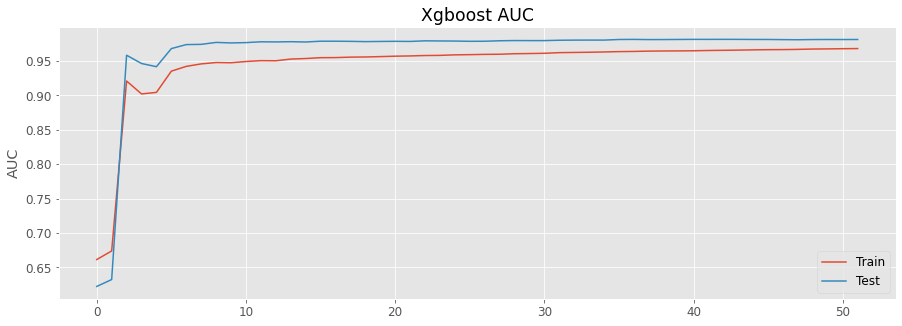

In [68]:
%matplotlib inline 
print('\033[4mModel performance :: Quality of Classifier\033[0m')
plt.rcParams['figure.figsize'] = 15, 5 
plt.rcParams['font.size'] = 12

history = xgb_clf1.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label = 'Train')
plt.plot(x_axis, history['validation_1']['auc'], label = 'Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

### ***Features importance***

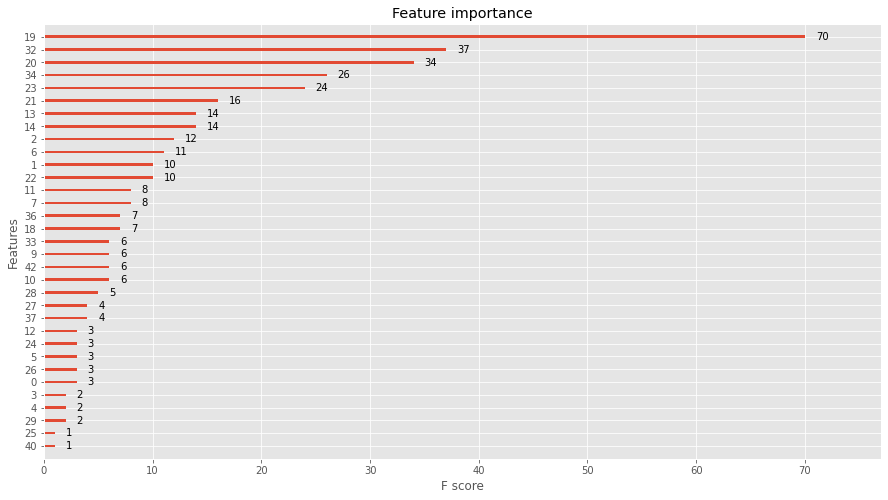

In [69]:
%matplotlib inline
# Feature importance
plt.rcParams['figure.figsize'] = [15, 8]
plot_importance(xgb_clf1)
print('\n')

In [0]:
%matplotlib inline
fig = plt.figure(figsize=(20,5))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgb_clf1.feature_importances_))], xgb_clf1.feature_importances_.tolist(), 
        tick_label=df.columns, color="chocolate")
plt.title('Feature importance plot')
plt.show()
#print('\n')

### ***Predictions for test data***

In [0]:
# make predictions for test data
y_pred = xgb_clf1.predict(X_test, ntree_limit = ntree_limit)
#predictions = [round(value) for value in y_pred]

### ***Prediction probability***
The predicted probability are the votes, i.e. the proportion of trees who voted for class 1 & 0. 

In [71]:
pred_prob = xgb_clf1.predict_proba(X_test[:5], ntree_limit = ntree_limit)
print('\033[4mProbability of prediction results\033[0m')
pred_prob = pd.DataFrame(pred_prob)
round(pred_prob.tail(),2)

Probability of prediction results


<IPython.core.display.Javascript object>

,0,1
0,0.06,0.94
1,0.31,0.69
2,0.94,0.06
3,0.94,0.06
4,0.06,0.94


### ***Confusion matrix*** 

In [72]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report 


results = confusion_matrix(y_test, y_pred) 

print('Confusion Matrix :')
print(results)
print('\n') 

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('\n')

print ('Report : ')
print (classification_report(y_test, y_pred)) 


Confusion Matrix :
[[441  26]
 [ 14 367]]


Accuracy: 95.28%


Report : 
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       467
           1       0.93      0.96      0.95       381

    accuracy                           0.95       848
   macro avg       0.95      0.95      0.95       848
weighted avg       0.95      0.95      0.95       848



We have 28 false false positive and 15 false negative from 847 observations which is quite low. 

**Classification Rate/Accuracy:**
- Accuracy = (TP + TN) / (TP + TN + FP + FN) 

**Recall:** 
- Recall gives us an idea about when it’s actually yes, how often does it predict yes.
Recall = TP / (TP + FN) 

**Precision:** 
- Precsion tells us about when it predicts yes, how often is it correct.
Precision = TP / (TP + FP)

**F-measure:**
- Fmeasure = (2 * Recall * Precision) / (Recall + Presision) 

In [73]:
print('\033[4mNext day Open price direction\033[0m')
pred = pd.DataFrame(y_pred)
pred = (pred[:5])
pred

Next day Open price direction


<IPython.core.display.Javascript object>

,0
0,1
1,1
2,0
3,0
4,1


### ***Assigning date to predicted signal***

In [74]:
# assigning date to the predicted values
df['price_direction'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day 

for i in pred:
  next_date = datetime.datetime.fromtimestamp(next_unix)
  next_unix += one_day
  df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

#create an index of just the date portion of our index (this is the slow step)
ts_days = pd.to_datetime(df['price_direction'].index.date)

#create a range of business days over that period
bdays = pd.bdate_range(start=df['price_direction'].index[0].date(), end=df['price_direction'].index[-1].date())

#Filter the series to just those days contained in the business day range.
#df['price_direction'] = round(df.price_direction[ts_days.isin(bdays)],2)
#print('\033[4mExpected Open price direction for next 5 days\033[0m')
#df['price_direction'].tail()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [75]:
# assigning dates to dataframes
a = df.sort_values(by='Date', ascending=False)
pred.index = a.index[:5]
print(pred.index)

# assigning names to columns
pred.rename(columns = {0: 'price_direction'}, inplace=True)
pred

DatetimeIndex(['2020-04-24', '2020-04-23', '2020-04-22', '2020-04-21', '2020-04-20'], dtype='datetime64[ns]', name='Date', freq=None)


,price_direction
Date,
2020-04-24,1
2020-04-23,1
2020-04-22,0
2020-04-21,0
2020-04-20,1


### ***BUY/SELL signal plot***

For each day where open price = 0 = red arrow head  and 1 = green arrow head 


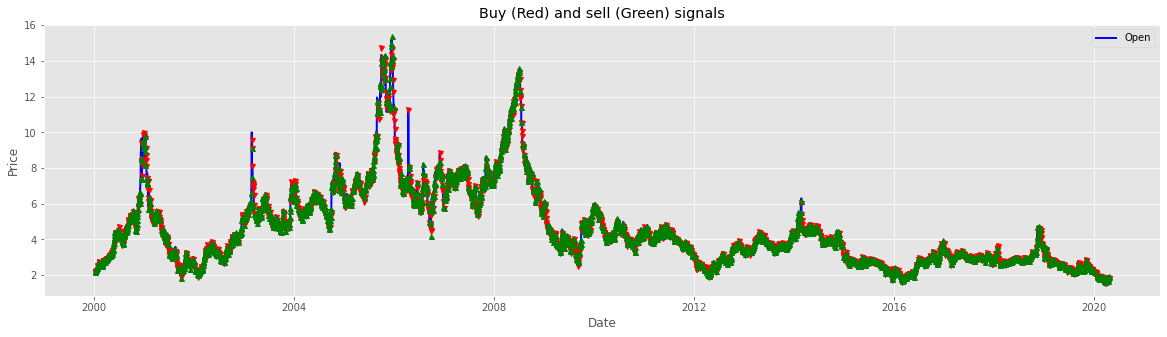

In [34]:
# For each day where open price > 0, we set the signal 1 means sell  and < 0, we set signal 0, to buy 

print('\033[4mFor each day where open price = 0 = red arrow head  and 1 = green arrow head \033[0m')
buys = df.loc[df['label'] == -0]
sells = df.loc[df['label'] == 1]

# Plot 
fig = plt.figure(figsize=(20, 5))
plt.plot(df.index, df['Open'], color = 'b', lw=2., label='Open')

# Plot the buy and sell signals on the same plot
plt.plot(buys.index, df.loc[buys.index]['Last'], 'v', markersize=5, color='r')
plt.plot(sells.index, df.loc[sells.index]['Last'], '^', markersize=5, color='g')
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('Buy (Red) and sell (Green) signals')
plt.legend(loc=0)

# Display everything
plt.show()
print('\n')

### ***Last 5 Buy signals***

In [35]:
print('\033[4mLast 5 Buy signal \033[0m')
buy = (round(df.loc[buys.index], 2)['Last'].tail())
buy = buy.reset_index()
buy

Last 5 Buy signal 


,Date,Last
0,2020-04-13,1.73
1,2020-04-14,1.63
2,2020-04-15,1.59
3,2020-04-21,1.83
4,2020-04-23,1.82


### ***Last 5 Sell signals***

In [36]:
print('\033[4mLast 5 Sell signal \033[0m')
sell = (round(df.loc[sells.index], 2)['Last'].tail())
sell = sell.reset_index()
sell

Last 5 Sell signal 


,Date,Last
0,2020-04-07,1.91
1,2020-04-16,1.69
2,2020-04-17,1.76
3,2020-04-20,1.94
4,2020-04-22,1.91


## **Predicting movement of gas price**

Now that the classifier has been compiled, we can use the predict() method for making the prediction. We pass X_test as its argument and store the result in a variable named y_pred. We then convert y_pred to store binary values by storing the condition ypred > 5. Now, the variable ypred stores either True or False depending on whether the predicted value was greater or less than 0.5.

In [0]:
ypred = (y_pred > 0.5)

Next, we create a new column in the dataframe dataset with the column header ‘ypred’ and store NaN values in the column. We then store the values of ypred into this new column, starting from the rows of the test dataset. This is done by slicing the dataframe using the iloc method as shown in the code above. We then drop all the NaN values from the dataset and store them in a new dataframe named trade_dataset.

In [77]:
df['ypred'] = np.NaN
df.iloc[(len(df) - len(ypred)):,-1:] = ypred
trade_dataset = df.copy()
#trade_dataset

<IPython.core.display.Javascript object>

In [78]:
td = trade_dataset['ypred'].tail()
td


Date
2020-04-20     True
2020-04-21     True
2020-04-22    False
2020-04-23     True
2020-04-24    False
Name: ypred, dtype: object

In [79]:
forecast = pd.concat([td, pred], axis=1) # combining dataframes to see actutal vs predicted
forecast = forecast.reset_index()
forecast.sort_values(by=['Date'], inplace=True, ascending=False)
forecast

<IPython.core.display.Javascript object>

,Date,ypred,price_direction
4,2020-04-24,False,1
3,2020-04-23,True,1
2,2020-04-22,False,0
1,2020-04-21,True,0
0,2020-04-20,True,1


## **Computing Strategy Returns**
- With the predicted values of the price movement, we can compute the returns of the strategy. 
- We will be taking a long position when the predicted value of y is true and will take a short position when the predicted signal is False.
- We first compute the returns that the strategy will earn if a long position is taken at the end of today, and squared off at the end of the next day. 
- We start by creating a new column named ‘Tomorrows Returns’ in the trade_dataset and store in it a value of 0. 
- We use the decimal notation to indicate that floating point values will be stored in this new column. 
- Next, we store in it the log returns of today, i.e. logarithm of the opening price of today divided by the opening price of yesterday. 
- Next, we shift these values upwards by one element so that tomorrow’s returns are stored against the prices of today.

In [41]:
trade_dataset['tomorrows_returns'] = 0.
trade_dataset['tomorrows_returns'] = np.log(trade_dataset['Last']/trade_dataset['Last'].shift(1))
trade_dataset['tomorrows_returns'] = round(trade_dataset['tomorrows_returns'],2).shift(-1)

<IPython.core.display.Javascript object>

In [42]:
trade_dataset['tomorrows_returns'].tail()

Date
2020-04-20   -0.06
2020-04-21    0.04
2020-04-22   -0.05
2020-04-23     NaN
2020-04-24     NaN
Name: tomorrows_returns, dtype: float64

Next, we will compute the Strategy Returns. 

We create a new column under the header ‘StrategyReturns’ and initialize it with a value of 0. to indicate storing floating point values. 

By using the np.where() function, we then store the value in the column ‘Tomorrows Returns’ if the value in the ‘y_pred’ column stores True (a long position), else we would store negative of the value in the column ‘Tomorrows Returns’ (a short position); into the ‘Strategy Returns’ column.

In [43]:
trade_dataset['strategy_returns'] = 0.
trade_dataset['strategy_returns'] = np.where(trade_dataset['ypred'] == True, 
                                            trade_dataset['tomorrows_returns'], - trade_dataset['tomorrows_returns'])

<IPython.core.display.Javascript object>

In [44]:
round(trade_dataset['strategy_returns'],2).tail()

Date
2020-04-20   -0.06
2020-04-21    0.04
2020-04-22    0.05
2020-04-23     NaN
2020-04-24     NaN
Name: strategy_returns, dtype: float64

We now compute the cumulative returns for both the market and the strategy. These values are computed using the cumsum() function. We will use the cumulative sum to plot the graph of market and strategy returns in the last step.

In [45]:
trade_dataset['cumulative_market_returns'] = np.cumsum(trade_dataset['tomorrows_returns'])
trade_dataset['cumulative_strategy_returns'] = np.cumsum(trade_dataset['strategy_returns'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We will now plot the market returns and our strategy returns to visualize how our strategy is performing against the market. For this, we will import matplotlib.pyplot. We then use the plot function to plot the graphs of Market Returns and Strategy Returns using the cumulative values stored in the dataframe trade_dataset. We then create the legend and show the plot using the legend() and show() functions respectively.

The plot shown below is the output of the code. The green line represents the returns generated using the strategy and the red line represents the market returns.

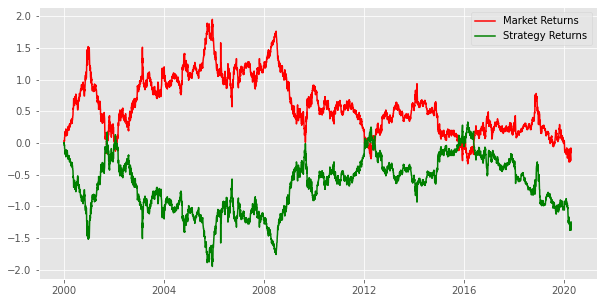

In [46]:
plt.figure(figsize=(10,5))
plt.plot(trade_dataset['cumulative_market_returns'], color='r', label='Market Returns')
plt.plot(trade_dataset['cumulative_strategy_returns'], color='g', label='Strategy Returns')
plt.legend()
plt.show()

In [47]:
trade_dataset['cumulative_strategy_returns']

Date
2000-01-04    0.00
2000-01-05   -0.01
2000-01-06    0.00
2000-01-07   -0.02
2000-01-10   -0.04
              ... 
2020-04-20   -1.34
2020-04-21   -1.30
2020-04-22   -1.25
2020-04-23     NaN
2020-04-24     NaN
Name: cumulative_strategy_returns, Length: 5092, dtype: float64

In [48]:
trade_dataset['cumulative_market_returns']

Date
2000-01-04   -0.00
2000-01-05    0.01
2000-01-06    0.00
2000-01-07    0.02
2000-01-10    0.04
              ... 
2020-04-20   -0.14
2020-04-21   -0.10
2020-04-22   -0.15
2020-04-23     NaN
2020-04-24     NaN
Name: cumulative_market_returns, Length: 5092, dtype: float64

# **Moving averages crossover strategy**

We create two separate Simple Moving Averages (SMA) with differing lookback periods, 10 days and 200 days. If the short moving average exceeds the long moving average then you go long, if the long moving average exceeds the short moving average then you exit.

When we go long, we think that the stock price will go up and will sell at a higher price in the future (= buy signal); When we go short, we sell our stock, expecting that we can buy it back at a lower price and realize a profit (= sell signal).

Steps:
- We already have tow look back period 10 & 200
- Next, make an empty signals DataFrame, ensure to copy the index of our 'df' data so that we can start calculating the daily buy or sell signal.
- Create a column in our empty signals DataFrame that is named signal and initialize it by setting the value for all rows in this column to 0.0.
- After the preparatory work, it’s time to create the set of short and long simple moving averages over the respective long and short time windows. Make use of the rolling() function to start your rolling window calculations: within the function, specify the window and the min_period, and set the center argument. In practice, this will result in a rolling() function to which we have passed either short_window or long_window, 1 as the minimum number of observations in the window that are required to have a value, and False, so that the labels are not set at the center of the window. 
-After we have calculated the mean average of the short and long windows, we create a signal when the short moving average crosses the long moving average, but only for the period greater than the shortest moving average window. 

In Python, this will result in a condition: 
signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:]. 

Here we add the [short_window:] to comply with the condition “only for the period greater than the shortest moving average window”. 

When the condition is true, the initialized value 0.0 in the signal column will be overwritten with 1.0. A “signal” is created! If the condition is false, the original value of 0.0 will be kept and no signal is generated. we used the NumPy where() function to set up this condition. 

Much the same like you read just now, the variable to which we assign this result is signals['signal'][short_window], because we only want to create signals for the period greater than the shortest moving average window!
- Lastly, we take the difference of the signals in order to generate actual trading orders. In other words, in this column of our signals DataFrame, we’ll be able to distinguish between long and short positions, whether we’re buying or selling stock.

In [0]:
# Initialize the short and long windows
short_window = 10
long_window = 100

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_ma'] = df['Last'].rolling(window=short_window, 
                                         min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_ma'] = df['Last'].rolling(window=long_window, 
                                         min_periods=1, center=False).mean()
# Create signals
signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                            > signals['long_ma'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print `signals`
print(signals)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

            signal  short_ma   long_ma  positions
Date                                             
2000-01-04     0.0  2.176000  2.176000        NaN
2000-01-05     0.0  2.172000  2.172000        0.0
2000-01-06     0.0  2.180000  2.180000        0.0
2000-01-07     0.0  2.178250  2.178250        0.0
2000-01-10     0.0  2.185800  2.185800        0.0
...            ...       ...       ...        ...
2020-04-20     0.0  1.753400  1.961380        0.0
2020-04-21     0.0  1.761300  1.954450        0.0
2020-04-22     0.0  1.761500  1.948980        0.0
2020-04-23     0.0  1.763800  1.942210        0.0
2020-04-24     0.0  1.765667  1.938465        0.0

[5092 rows x 4 columns]


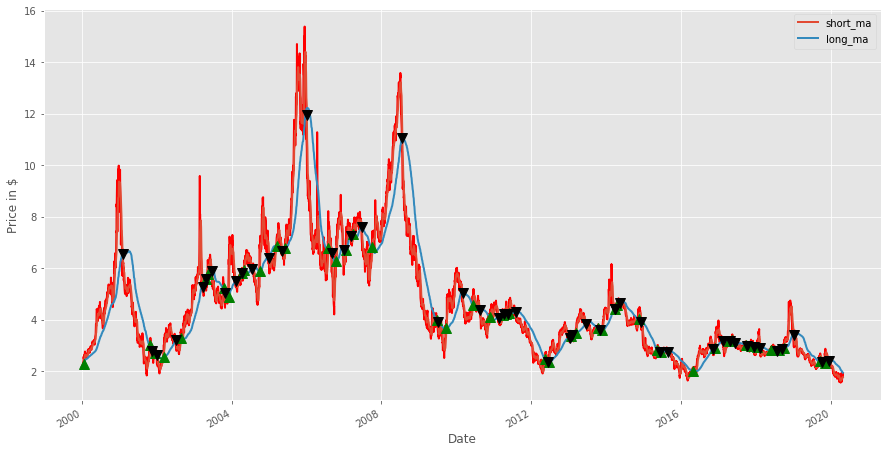

In [0]:
# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
df['Last'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_ma', 'long_ma']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_ma[signals.positions == 1.0],
         '^', markersize=10, color='g')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_ma[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

## **Backtesting SMA strategy**

We’ve got your trading strategy at hand, it’s a good idea to also backtest it and calculate its performance. 

### ***Backtesting Pitfalls***
Backtesting is, besides just “testing a trading strategy”, testing the strategy on relevant historical data to make sure that it’s an actual viable strategy before we start making moves. 

With backtesting, a trader can simulate and analyze the risk and profitability of trading with a specific strategy over a period of time. 

However, when we’re backtesting, it’s a good idea to keep in mind that there are some pitfalls, which might not be obvious to us when you’re just starting out.

For example, there are external events, such as market regime shifts, which are regulatory changes or macroeconomic events, which definitely influence your backtesting. Also, liquidity constraints, such as the ban of short sales, could affect your backtesting heavily.

Next, there are pitfalls which you might introduce ourself when we, for example, 
- overfit a model (optimization bias), when we ignore strategy rules because you think it’s better like that (interference), or 
- when we accidentally introduce information into past data (lookahead bias).

### ***Impmentation of a simple backtest***
we will create a portfolio which can generate orders and manages the profit and loss:

- First off, we’ll create set a variable initial_capital to set your initial capital and a new DataFrame positions. Once again, we copy the index from another DataFrame; In this case, this is the signals DataFrame because you want to consider the time frame for which you have generated the signals.
- Next, we create a new column NG in the DataFrame. On the days that the signal is 1 and the short moving average crosses the long moving average (for the period greater than the shortest moving average window, we’ll buy a 100 shares. 
- The days on which the signal is 0, the final result will be 0 as a result of the operation 100*signals['signal'].
- A new DataFrame portfolio is created to store the market value of an open position.
- Next, we create a DataFrame that stores the differences in positions (or number of stock)

Then the real backtesting begins: 
- we create a new column to the portfolio DataFrame with name holdings, which stores the value of the positions or shares you have bought, multiplied by the ‘Settle’ price.
- Our portfolio also contains a cash column, which is the capital that you still have left to spend: it is calculated by taking our initial_capital and subtracting our holdings (the price that we paid for buying stock).
- We’ll also add a total column to our portfolio DataFrame, which contains the sum of our cash and the holdings that we own, and
- Lastly, we also add a returns column to our portfolio, in which we’ll store the returns

In [0]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['NG'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(df['Settle'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(df['Settle'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(df['Settle'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
portfolio.tail()

<IPython.core.display.Javascript object>

,NG,holdings,cash,total,returns
Date,,,,,
2020-04-20,0.0,0.0,99763.2,99763.2,0.0
2020-04-21,0.0,0.0,99763.2,99763.2,0.0
2020-04-22,0.0,0.0,99763.2,99763.2,0.0
2020-04-23,0.0,0.0,99763.2,99763.2,0.0
2020-04-24,NaN,0.0,99763.2,99763.2,0.0


Let's visualize the portfolio value or portfolio['total'] over the years with the help of our backtest:

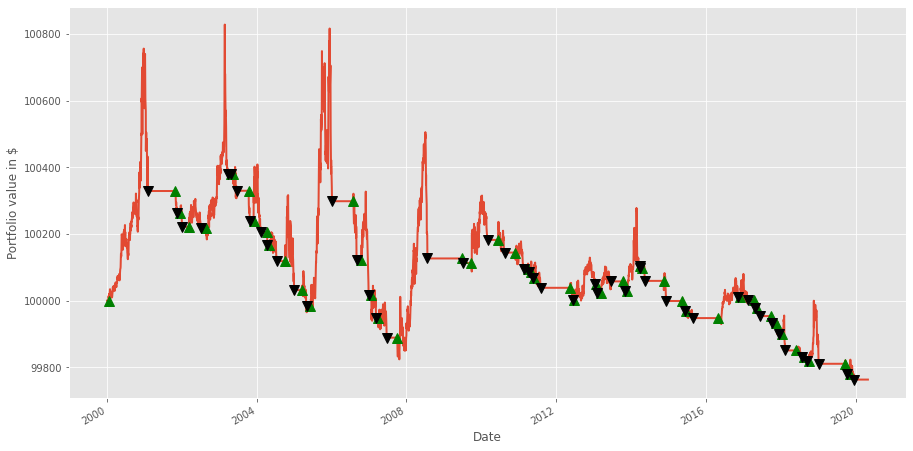

In [0]:
# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='g')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

## ***Backtesting with Quantopian***

In [0]:
def initialize(context):
    context.sym = symbol('NG')
    context.i = 0


def handle_data(context, data):
    # Skip first 200 days to get full windows
    context.i += 1
    if context.i < 200:
        return

    # Compute averages history() has to be called with the same params
    # from above and returns a pandas dataframe.
    short_ma = data.history(context.sym, 'price', 10, '1d').mean()
    long_ma = data.history(context.sym, 'price', 200, '1d').mean()

    # Trading logic
    if short_ma > short_ma:
        # order_target orders as many shares as needed to achieve the desired number of shares.
        order_target(context.sym, 20)
    elif short_ma < long_na:
        order_target(context.sym, 0)

    # Save values for later inspection
    record(NG=data.current(context.sym, "price"),
           short_ma = short_ma,
           long_ma = long_ma)

### ***Moving Average Crossover Strategy evaluation***
We can use the Sharpe ratio to get to know whether our returns are the result of the fact that we decided to make smart investments or to take a lot of risks.

The ideal situation is, of course, that the returns are considerable but that the additional risk of investing is as small as possible. That’s why, the greater the portfolio’s Sharpe ratio, the better: 

- the ratio between the returns and the additional risk that is incurred is quite OK. 
- Usually, a ratio:
  - > 1 is acceptable by investors, 
  - >2 is very good and 
  - >3 is excellent.

In [0]:
# Isolate the returns of your strategy
returns = portfolio['returns']

# annualized Sharpe ratio
SharpeRatio = np.sqrt(252) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(SharpeRatio)

<IPython.core.display.Javascript object>

-0.012108031074349834


## **SMA strategy for dashboard**

In [0]:
df1 = merge13.apply(copy.deepcopy)

# moving average crossover :: sma 252 is > sma 42
df1['target'] = np.where(df1['sma1'] > df1['sma2'], 1,0)
#df1 = df1.fillna(0)
df1['target'].tail()
#print('\n')

def getBinary(val):
    if val<0:
        return 0
    else:
        return 1
df1['next_day_direction'] = df1["target"].apply(getBinary)


print('\033[4mSell-> Shorter MA crosses above the longer-term MA (Golden cross)\033[0m')
print('\033[4mBuy-> Shorter MA crosses below the longer-term MA(Dead cross)\033[0m')
buys = df1.loc[df1['next_day_direction'] == 0]
sells = df1.loc[df1['next_day_direction'] == 1]
print('\n')

print("\033[4mBuys data to checking\033[0m")
print(round(df1.loc[buys.index]['Last'],2).tail())
print('\n')
print("\033[4mSells data to checking\033[0m")
print(round(df1.loc[sells.index]['Last'],2).tail())


<IPython.core.display.Javascript object>

Sell-> Shorter MA crosses above the longer-term MA (Golden cross)
Buy-> Shorter MA crosses below the longer-term MA(Dead cross)


Buys data to checking
Series([], Name: Last, dtype: float64)


Sells data to checking
Date
2020-04-16    1.69
2020-04-17    1.76
2020-04-20    1.94
2020-04-21    1.83
2020-04-22    1.91
Name: Last, dtype: float64


### ***SMA crossover visualization***

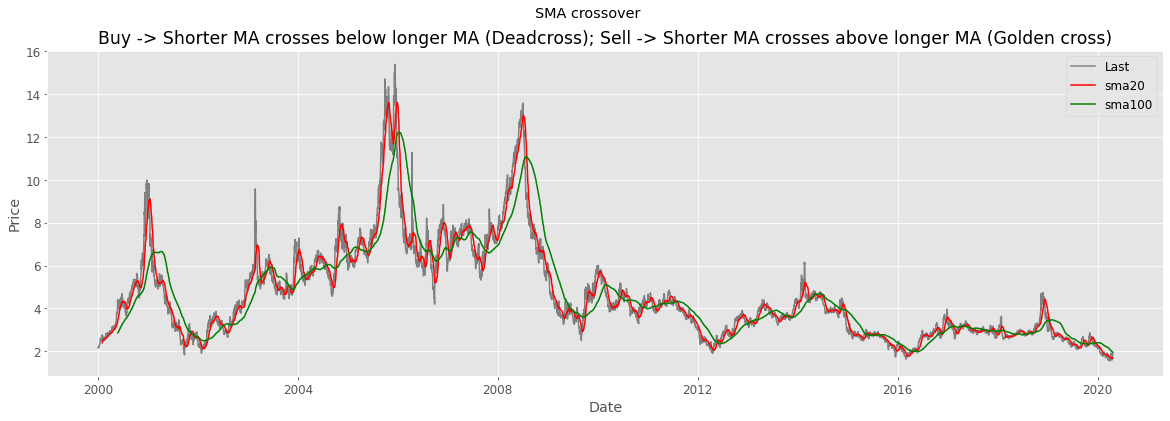

In [0]:
# Plot 
fig = plt.figure(figsize=(20,6))
plt.plot(df1['Last'], color='gray', label='Last')
# Plot the buy and sell signals on the same plot
#  When the shorter-term MA crosses above the longer-term MA (Golden cross), it's a buy signal, it indicates that the trend is shifting up. 
#  When the shorter-term MA crosses below the longer-term MA, it's a sell signal (dead/death cross), it indicates that the trend is shifting down. 
plt.plot(df1['sma3'].dropna(), color='r', label = 'sma20')
plt.plot(df1['sma5'].dropna(), color='g', label = 'sma100')
plt.ylabel('Price')
plt.xlabel('Date')
plt.suptitle('SMA crossover')
plt.title('Buy -> Shorter MA crosses below longer MA (Deadcross); Sell -> Shorter MA crosses above longer MA (Golden cross)')
plt.legend(loc=0)

# Display everything
plt.show()
print('\n')


## **5 days look-ahead Open price**


### ***Feature engineering (Open variable)***

In [0]:
## 5 days look-ahead Open price

df4 = merge12.apply(copy.deepcopy)

sma1 = 3
sma2 = 10
sma3 = 20
sma4 = 30
sma5 = 100
df4["sma1"] = df4['Open'].shift(1).rolling(sma1).mean()
df4["sma2"] = df4['Open'].shift(1).rolling(sma2).mean()
df4['sma3'] = df4['Open'].shift(1).rolling(sma3).mean()
df4['sma4'] = df4['Last'].shift(1).rolling(sma4).mean()
df4['sma5'] = df4['Last'].shift(1).rolling(sma5).mean()
df4['Std_dev']= df4['Last'].rolling(5).std()

#merge13['ema42'] = merge13['Open'].ewm(span=42).mean()
#merge13['ema252'] = merge13['Open'].ewm(span=252).mean()

df4['ema_12'] = df4['Open'].ewm(span=10).mean()
df4['ema_26'] = df4['Open'].ewm(span=26).mean()
df4['ROC'] = ((df4['Open'] - df4['Open'].shift(5)) / (df4['Open'].shift(5)))*100

delta = merge13['Last'].diff()
window = 14
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
df4['rsi'] = 100-100/(1+RS_up/RS_down)
df4['macd'] = df4['ema_12'] - df4['ema_26']
df4['Williams%R'] = (df4['High'].max() - df4['Last'])/(df4['High'] - df4['Low'].min()) * -100

#print('\033[4mMerged dataframe\033[0m')
#print(df.info())
#print('\n')

# WINDOW FEATURE

df4['t-2'] = df4['Open'].shift(2)
df4['t-1'] = df4['Open'].shift(1)

# ROLLING WINDOW FEATURE

width = 3
shifted = df4['Open'].shift(width - 1)
roll_window = shifted.rolling(window=width)
df4['min'] = roll_window.min()
df4['mean'] = roll_window.mean()
df4['max'] = roll_window.max()

# EXPANDING WINDOW STATISTICS

exp_window = df4['Open'].expanding()
df4['min_exp'] = exp_window.min()
df4['mean_exp'] = exp_window.mean()
df4['max_exp'] = exp_window.max()

### ***Information of dataframe***

In [83]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5091 entries, 2000-01-04 to 2020-04-23
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Open                        5091 non-null   float64
 1   High                        5091 non-null   float64
 2   Low                         5091 non-null   float64
 3   Last                        5091 non-null   float64
 4   Change                      5091 non-null   float64
 5   Settle                      5091 non-null   float64
 6   Volume                      5091 non-null   float64
 7   Previous Day Open Interest  5091 non-null   float64
 8   gdp                         5091 non-null   float64
 9   wti                         5091 non-null   float64
 10  withdrawals                 5091 non-null   float64
 11  storage                     5091 non-null   float64
 12  prod                        5091 non-null   float64
 13  consumption    

In [84]:
df4 = df4.astype(float)
df4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5091 entries, 2000-01-04 to 2020-04-23
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Open                        5091 non-null   float64
 1   High                        5091 non-null   float64
 2   Low                         5091 non-null   float64
 3   Last                        5091 non-null   float64
 4   Change                      5091 non-null   float64
 5   Settle                      5091 non-null   float64
 6   Volume                      5091 non-null   float64
 7   Previous Day Open Interest  5091 non-null   float64
 8   gdp                         5091 non-null   float64
 9   wti                         5091 non-null   float64
 10  withdrawals                 5091 non-null   float64
 11  storage                     5091 non-null   float64
 12  prod                        5091 non-null   float64
 13  consumption    

### ***Open price Predcitor variable***

In [0]:
# A variable for predicting 'n' days out into the future
n = int(5) #'n=5' days
future_pred = n 

#Create another column (the target or dependent variable) shifted 'n' units up
df4['Prediction'] = df4['Open'].shift(-future_pred)

#print the new data set
#print(df4)

### ***Setting up unseen data (Open price)***

In [86]:
X3 = np.array(df4.drop(columns = ['Prediction',
                                  'day_of_week',
                                  'Change',
                                  'Volume',
                                  'Open',
                                  'High',
                                  'Low',
                                  'Last',
                                  'Settle',
                                  'Previous Day Open Interest'], axis=1))
                         
X3_forecast = X3[-future_pred:] # set X3_forecast equal to last 5, we do not have y3 values for X3_forecast
X3 = X3[:-future_pred] # remove last 5 from X3
y3 = np.array(df4['Prediction'])
y3 = y3[:-future_pred]
print(len(X3), len(y3))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

5086 5086


### ***Time-series cross validation***

In [87]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.33, random_state=42)


tscv = TimeSeriesSplit()
#print(tscv)
TimeSeriesSplit(max_train_size=0.67, n_splits=5)
for train_index, test_index in tscv.split(X3):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X3_train, X3_test = X3[train_index], X3[test_index]
  y3_train, y3_test = y3[train_index], y3[test_index]


eval_set = [(X3_train, np.ravel(y3_train)), (X3_test, np.ravel(y3_test))]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [88]:
print('Length train set: {}'.format(len(y3_train)))
print('Length test set: {}'.format(len(y3_test)))

Length train set: 4239
Length test set: 847


In [0]:
from xgboost import XGBRegressor
import xgboost as xgb

### ***Fitting model and validation***

In [90]:
reg2 = xgb.XGBRegressor(objective ='reg:squarederror',
                        colsample_bytree = 0.3, 
                        learning_rate = 0.1, 
                        max_depth = 5, 
                        alpha = 10, 
                        n_estimators = 100,
                        random_state = 42)


reg2.fit(X3_train, y3_train, 
         eval_metric = 'rmse', 
         eval_set = eval_set,
         early_stopping_rounds = 10, verbose = 10)

[0]	validation_0-rmse:4.51627	validation_1-rmse:2.11107
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[10]	validation_0-rmse:1.63065	validation_1-rmse:0.743462
[20]	validation_0-rmse:0.65088	validation_1-rmse:0.301139
[30]	validation_0-rmse:0.350673	validation_1-rmse:0.196945
[40]	validation_0-rmse:0.272072	validation_1-rmse:0.180616
[50]	validation_0-rmse:0.243364	validation_1-rmse:0.17818
[60]	validation_0-rmse:0.228204	validation_1-rmse:0.176412
[70]	validation_0-rmse:0.219233	validation_1-rmse:0.175705
[80]	validation_0-rmse:0.210045	validation_1-rmse:0.175602
Stopping. Best iteration:
[79]	validation_0-rmse:0.211259	validation_1-rmse:0.17528



XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

RMSE is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data–how close the observed data points are to the model's predicted values. RMSE has the same unit as the dependent variable (DV)

### ***Regression quality check***

Model performance :: Regression Quality


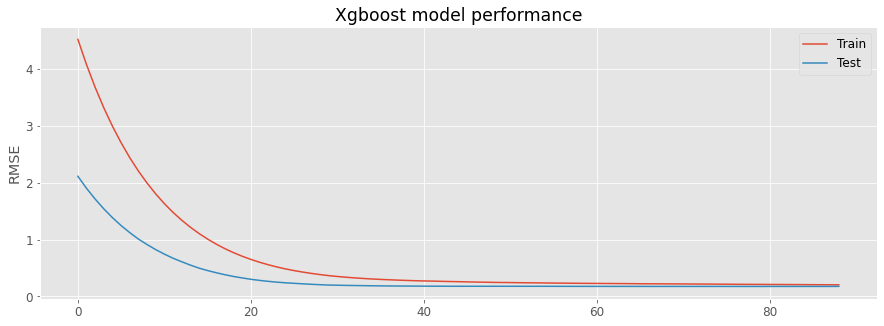

In [91]:
print('\033[4mModel performance :: Regression Quality\033[0m')
plt.rcParams['figure.figsize'] = 15, 5 
plt.rcParams['font.size'] = 12

history = reg2.evals_result_
x_axis = range(len(history['validation_0']['rmse']))
plt.plot(x_axis, history['validation_0']['rmse'], label = 'Train')
plt.plot(x_axis, history['validation_1']['rmse'], label = 'Test')
plt.legend(loc = 'best')
plt.ylabel('RMSE')
plt.title('Xgboost model performance')
plt.show()

### ***Feature importance plot***

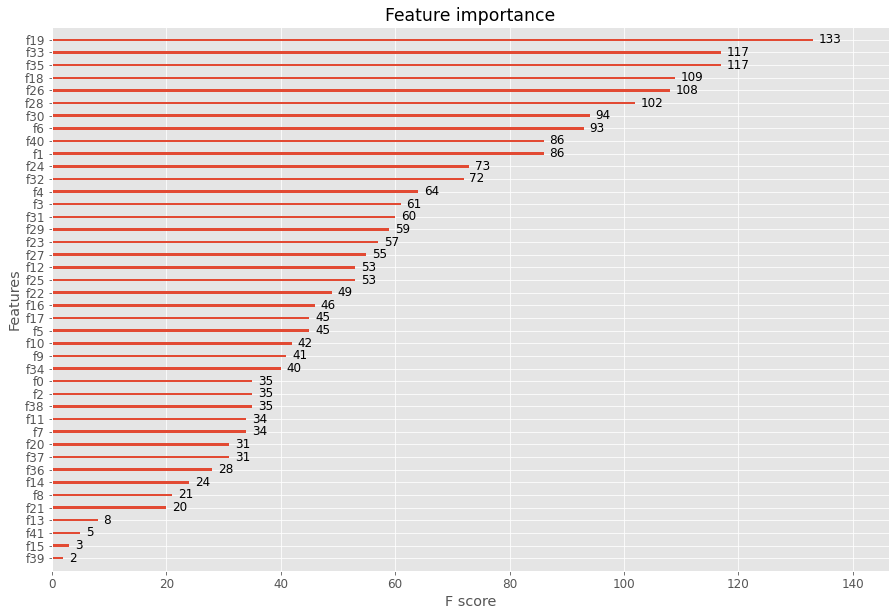

In [92]:
# Feature importance
plt.rcParams['figure.figsize'] = [15, 10]
plot_importance(reg2)

### ***Confidence on Test data***

In [93]:
open_confidence = reg2.score(X3_test, y3_test)
print("open_confidence: ", round(open_confidence*100,2).astype(str) + '%')

open_confidence:  88.04%


### ***Open prediction on test data & Prediction Accuracy***

In [94]:
xgb_open_pred = reg2.predict(X3_test) # prediction on test data
xgb_open_pred = np.sort(xgb_open_pred) # sorting data in decending order

# assigning dataframes
xgb_open_pred = pd.DataFrame(xgb_open_pred)

xgb_open_pred = round(xgb_open_pred[:5],2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [95]:
# assigning names to columns
xgb_open_pred.rename(columns = {0: 'prediction'}, inplace=True)
xgb_open_pred

,prediction
0,1.76
1,1.80
2,1.81
3,1.82
4,1.82


In [96]:
# assigning dates to dataframes
d = df4.sort_values(by='Date', ascending=False)
xgb_open_pred.index = d.index[:5]
xgb_open_pred.index
print('\n')
xgb_open_pred

,prediction
Date,
2020-04-23,1.76
2020-04-22,1.80
2020-04-21,1.81
2020-04-20,1.82
2020-04-17,1.82


In [97]:
combine_open = pd.concat([df4['Open'].tail(), xgb_open_pred], axis=1) # combining dataframes to see actutal vs predicted
combine_open

<IPython.core.display.Javascript object>

,Open,prediction
Date,,
2020-04-17,1.689,1.82
2020-04-20,1.774,1.82
2020-04-21,1.943,1.81
2020-04-22,1.836,1.80
2020-04-23,1.910,1.76


In [98]:
# using apply function to create a new column 
combine_open['accuracy'] = round(combine_open.apply(lambda row: row.prediction / 
                                            row.Open *100, axis = 1),2).astype(str) + '%' 
  
# Print the combined DataFrame after addition of new column 
combine_open

,Open,prediction,accuracy
Date,,,
2020-04-17,1.689,1.82,107.76%
2020-04-20,1.774,1.82,102.59%
2020-04-21,1.943,1.81,93.15%
2020-04-22,1.836,1.80,98.04%
2020-04-23,1.910,1.76,92.15%


In [99]:
combine_open = combine_open.reset_index()
combine_open

,Date,Open,prediction,accuracy
0,2020-04-17,1.689,1.82,107.76%
1,2020-04-20,1.774,1.82,102.59%
2,2020-04-21,1.943,1.81,93.15%
3,2020-04-22,1.836,1.80,98.04%
4,2020-04-23,1.910,1.76,92.15%


### ***Visualization***

In [100]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=combine_open['Date'],
    y=combine_open['Open'],
    name="Actual open price"       # this sets its legend entry
))


fig.add_trace(go.Scatter(
    x=combine_open['Date'],
    y=combine_open['prediction'],
    name="Predicted open price"
))

fig.update_layout(
    title="Actual vs Predicted Open Price",
    #xaxis_title="Date",
    yaxis_title="Price ($/Mbtu)",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)
fig.update_layout(
    autosize=False,
    width=500,
    height=500,)
fig.update_layout(legend_orientation="h")
fig.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### ***5 days Open prediction***

In [101]:
forecast_pred_2 = reg2.predict(X3_forecast)
print('\033[4mExpected Open price for next 5 days\033[0m')
print(forecast_pred_2)

Expected Open price for next 5 days
[1.8864045 2.0574844 1.9603748 1.9943465 1.9790112]


### ***Error accumulation***
We were startled that sometimes when our models achieved very small errors while predicting a single day to 5 days ahead, their 90 day forecast error would grow. The reason for that is a discrepancy between our training target and the test target – we were training the models to predict a single day ahead but used them to make longer predictions. 

This has two traps:

The first problem is that for the long-term predictions it’s possible that the whole input to the latter data points is entirely based on previous prediction thus the error may grow exponentially. It would be reasonable to assume that when  the error of our model on a single prediction decreases, the long-term error should decrease as well, because the model is more precise. 

This was, however, not the case: during training we were validating our models performance on single-day predictions, however later we wanted a good performance in the long-term. Predicting a single day and multiple days is not the same and our model was trained for the former while we expected it to be good at the latter. These two tasks have some differences, for example considering the  long-term trend and seasonality is not as important for single-day predictions so the model may ignore it, while it is essential for the long-term forecasts.

In [102]:
rmse1 = np.sqrt(mean_squared_error(y3_test[:future_pred], forecast_pred_2[:future_pred]))
print('Open Test RMSE: %.2f' % rmse1)

<IPython.core.display.Javascript object>

Open Test RMSE: 1.60


### ***Assigning date to predicted values***

In [103]:
# assigning date to the predicted values
df4['open_pred'] = np.nan
last_date = df4.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day 

for i in forecast_pred_2:
  next_date = datetime.datetime.fromtimestamp(next_unix)
  next_unix += one_day
  df4.loc[next_date] = [np.nan for _ in range(len(df4.columns)-1)] + [i]

#create an index of just the date portion of our index (this is the slow step)
ts_days = pd.to_datetime(df4['open_pred'].index.date)

#create a range of business days over that period
bdays = pd.bdate_range(start=df4['open_pred'].index[0].date(), end=df4['open_pred'].index[-1].date())

#Filter the series to just those days contained in the business day range.
df4['open_pred'] = round(df4.open_pred[ts_days.isin(bdays)],2)
print('\033[4mExpected Open price for next 5 days\033[0m')
df4['open_pred'].tail()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Expected Open price for next 5 days


Date
2020-04-24    1.89
2020-04-25     NaN
2020-04-26     NaN
2020-04-27    1.99
2020-04-28    1.98
Name: open_pred, dtype: float64

## **5 days look-ahead Close price**

### ***Feature Engineering (Close variable)***

In [0]:
## 5 days look-ahead Open price

df3 = merge12.apply(copy.deepcopy)

sma1 = 3
sma2 = 10
sma3 = 20
sma4 = 30
sma5 = 100
df3["sma1"] = df3['Last'].shift(1).rolling(sma1).mean()
df3["sma2"] = df3['Last'].shift(1).rolling(sma2).mean()
df3['sma3'] = df3['Last'].shift(1).rolling(sma3).mean()
df3['sma4'] = df3['Last'].shift(1).rolling(sma4).mean()
df3['sma5'] = df3['Last'].shift(1).rolling(sma5).mean()
df3['Std_dev']= df3['Last'].rolling(5).std()

df3['ema_12'] = df3['Last'].ewm(span=10).mean()
df3['ema_26'] = df3['Last'].ewm(span=26).mean()
df3['ROC'] = ((df3['Last'] - df3['Last'].shift(5)) / (df3['Last'].shift(5)))*100

delta = merge13['Last'].diff()
window = 14
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
df3['rsi'] = 100-100/(1+RS_up/RS_down)
df3['macd'] = df3['ema_12'] - df3['ema_26']
df3['Williams%R'] = (df3['High'].max() - df3['Last'])/(df['High'] - df3['Low'].min()) * -100

# WINDOW FEATURE

df3['t-2'] = df3['Last'].shift(2)
df3['t-1'] = df3['Last'].shift(1)

# ROLLING WINDOW FEATURE

width = 3
shifted = df3['Last'].shift(width - 1)
roll_window = shifted.rolling(window=width)
df3['min'] = roll_window.min()
df3['mean'] = roll_window.mean()
df3['max'] = roll_window.max()

# EXPANDING WINDOW STATISTICS

exp_window = df3['Last'].expanding()
df3['min_exp'] = exp_window.min()
df3['mean_exp'] = exp_window.mean()
df3['max_exp'] = exp_window.max()



### ***Information on dataframe***

In [108]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5091 entries, 2000-01-04 to 2020-04-23
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Open                        5091 non-null   float64
 1   High                        5091 non-null   float64
 2   Low                         5091 non-null   float64
 3   Last                        5091 non-null   float64
 4   Change                      5091 non-null   float64
 5   Settle                      5091 non-null   float64
 6   Volume                      5091 non-null   float64
 7   Previous Day Open Interest  5091 non-null   float64
 8   gdp                         5091 non-null   float64
 9   wti                         5091 non-null   float64
 10  withdrawals                 5091 non-null   float64
 11  storage                     5091 non-null   float64
 12  prod                        5091 non-null   float64
 13  consumption    

In [109]:
df3 = df3.astype(float)
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5091 entries, 2000-01-04 to 2020-04-23
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Open                        5091 non-null   float64
 1   High                        5091 non-null   float64
 2   Low                         5091 non-null   float64
 3   Last                        5091 non-null   float64
 4   Change                      5091 non-null   float64
 5   Settle                      5091 non-null   float64
 6   Volume                      5091 non-null   float64
 7   Previous Day Open Interest  5091 non-null   float64
 8   gdp                         5091 non-null   float64
 9   wti                         5091 non-null   float64
 10  withdrawals                 5091 non-null   float64
 11  storage                     5091 non-null   float64
 12  prod                        5091 non-null   float64
 13  consumption    

### ***Close Price Predictior variable***

In [0]:
# A variable for predicting 'n' days out into the future
n = int(5) #'n=5' days
pred_future = n 

#Create another column (the target or dependent variable) shifted 'n' units up
df3['prediction'] = df3['Last'].shift(-pred_future)

#print the new data set
#print(df3)

### ***Setting up unseen data (Close price)***

In [111]:
X2 = np.array(df3.drop(columns = ['prediction',
                                  'day_of_week',
                                  'Change',
                                  'Open',
                                  'High',
                                  'Low',
                                  'Last',
                                  'Settle',
                                  'Volume',
                                  'Previous Day Open Interest'], axis=1))
                         
X2_forecast = X2[-pred_future:] # set X2_forecast equal to last 5, we do not have y2 values for X2_forecast
X2 = X2[:-pred_future] # remove last 5 from X2
y2 = np.array(df3['prediction'])
y2 = y2[:-pred_future]
print(len(X2), len(y2))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

5086 5086


### ***Time-series cross validation (Close)***

In [112]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.33, random_state=42)

tscv = TimeSeriesSplit()
#print(tscv)
TimeSeriesSplit(max_train_size=0.67, n_splits=5)
for train_index, test_index in tscv.split(X2):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X2_train, X2_test = X2[train_index], X2[test_index]
  y2_train, y2_test = y2[train_index], y2[test_index]

eval_set = [(X2_train, np.ravel(y2_train)), (X2_test, np.ravel(y2_test))]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [113]:
print('Length train set: {}'.format(len(y2_train)))
print('Length test set: {}'.format(len(y2_test)))

Length train set: 4239
Length test set: 847


### ***Fitting model and validation***

In [114]:
reg1 = xgb.XGBRegressor(objective ='reg:squarederror',
                        colsample_bytree = 0.3, 
                        learning_rate = 0.1, 
                        max_depth = 5, 
                        alpha = 10, 
                        n_estimators = 100,
                        random_state = 42)


reg1.fit(X2_train, y2_train, 
         eval_metric = 'rmse', 
         eval_set = eval_set,
         early_stopping_rounds = 10, verbose = 10)

[0]	validation_0-rmse:4.50955	validation_1-rmse:2.10864
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[10]	validation_0-rmse:1.63096	validation_1-rmse:0.744189
[20]	validation_0-rmse:0.655696	validation_1-rmse:0.302217
[30]	validation_0-rmse:0.360172	validation_1-rmse:0.205343
[40]	validation_0-rmse:0.281921	validation_1-rmse:0.190969
[50]	validation_0-rmse:0.253617	validation_1-rmse:0.189979
[60]	validation_0-rmse:0.239527	validation_1-rmse:0.188743
[70]	validation_0-rmse:0.228306	validation_1-rmse:0.188848
Stopping. Best iteration:
[61]	validation_0-rmse:0.237154	validation_1-rmse:0.188741



XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

### ***Regression quality check***

Model performance :: Regression Quality


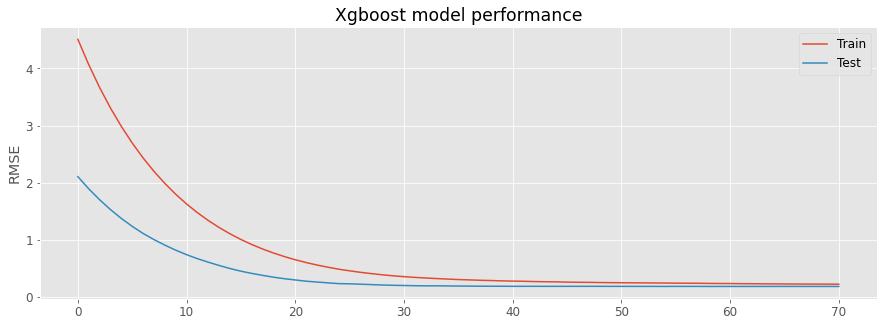

In [115]:
%matplotlib inline  
print('\033[4mModel performance :: Regression Quality\033[0m')
plt.rcParams['figure.figsize'] = 15, 5 
plt.rcParams['font.size'] = 12

history = reg1.evals_result_
x_axis = range(len(history['validation_0']['rmse']))
plt.plot(x_axis, history['validation_0']['rmse'], label = 'Train')
plt.plot(x_axis, history['validation_1']['rmse'], label = 'Test')
plt.legend(loc = 'best')
plt.ylabel('RMSE')
plt.title('Xgboost model performance')
plt.show()

### ***Feature importance for Close prediction***

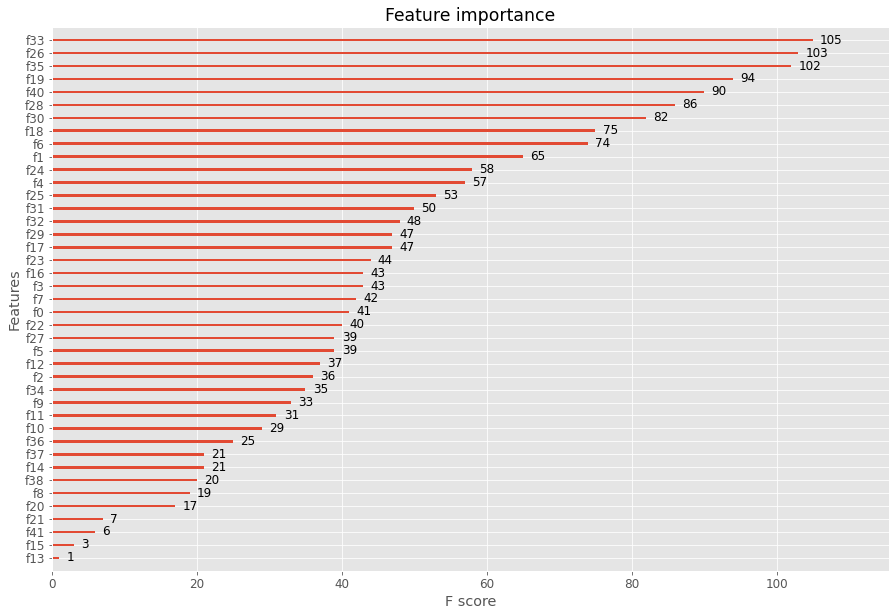

In [116]:
# Feature importance
plt.rcParams['figure.figsize'] = [15, 10]
plot_importance(reg1)
print('\n')

### ***Confidence check on test data***

In [117]:
close_confidence = reg1.score(X2_test, y2_test)
print("close_confidence: ", round(close_confidence*100,2).astype(str) + '%')

close_confidence:  86.23%


### ***Close prediction on test data & prediction accuracy***

In [118]:
xgb_close_pred = reg1.predict(X2_test) # prediction on test data
xgb_close_pred = np.sort(xgb_close_pred) # sorting data in decending order

# assigning dataframes
xgb_close_pred = pd.DataFrame(xgb_close_pred)

xgb_close_pred = round(xgb_close_pred[:5],2)


# assigning names to columns
xgb_close_pred.rename(columns = {0: 'prediction'}, inplace=True)

# assigning dates to 'combine' dataframes
e = df3.sort_values(by='Date', ascending=False)
xgb_close_pred.index = e.index[:5]
print(xgb_close_pred.index)
print('\n')
print(xgb_close_pred)

combine_close = pd.concat([df3['Last'].tail(), xgb_close_pred], axis=1) # combining dataframes to see actutal vs predicted
combine_close
print('\n')


# using apply function to create a new column 
combine_close['accuracy'] = round(combine_close.apply(lambda row: row.prediction / 
                                          row.Last *100, axis = 1),2).astype(str) + '%'
  
# Print the DataFrame after addition 
# of new column 
print(combine_close)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DatetimeIndex(['2020-04-23', '2020-04-22', '2020-04-21', '2020-04-20', '2020-04-17'], dtype='datetime64[ns]', name='Date', freq=None)


            prediction
Date                  
2020-04-23        1.81
2020-04-22        1.82
2020-04-21        1.84
2020-04-20        1.84
2020-04-17        1.84


<IPython.core.display.Javascript object>



             Last  prediction accuracy
Date                                  
2020-04-17  1.761        1.84  104.49%
2020-04-20  1.938        1.84   94.94%
2020-04-21  1.828        1.84  100.66%
2020-04-22  1.910        1.82   95.29%
2020-04-23  1.816        1.81   99.67%


In [119]:
combine_close = combine_close.reset_index()
combine_close

,Date,Last,prediction,accuracy
0,2020-04-17,1.761,1.84,104.49%
1,2020-04-20,1.938,1.84,94.94%
2,2020-04-21,1.828,1.84,100.66%
3,2020-04-22,1.910,1.82,95.29%
4,2020-04-23,1.816,1.81,99.67%


### ***Visualization***

In [120]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=combine_close['Date'],
    y=combine_close['Last'],
    name="Actual Close price"       # this sets its legend entry
))


fig.add_trace(go.Scatter(
    x=combine_close['Date'],
    y=combine_close['prediction'],
    name="Predicted Close price"
))

fig.update_layout(
    title="Actual vs Predicted Close Price",
    #xaxis_title="Date",
    yaxis_title="Price ($/Mbtu)",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)
fig.update_layout(
    autosize=False,
    width=500,
    height=500,)
fig.update_layout(legend_orientation="h")
fig.show()

 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### ***5 days Close price prediction***

In [121]:
forecast_pred_1 = reg1.predict(X2_forecast)
#print('\033[4mExpected Open price for next 5 days\033[0m')
print(forecast_pred_1)
print('\n')

rmse2 = np.sqrt(mean_squared_error(y2_test[:pred_future], forecast_pred_1[:pred_future]))
print('Close Test RMSE: %.2f' % rmse2)

[1.9588158 2.0666084 2.03047   2.0649014 1.9890743]




<IPython.core.display.Javascript object>

Close Test RMSE: 1.53


### ***Assigning date to Close predcited***

In [122]:
# assigning date to the predicted values
df3['close_pred'] = np.nan
last_date = df3.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day 

for i in forecast_pred_1:
  next_date = datetime.datetime.fromtimestamp(next_unix)
  next_unix += one_day
  df3.loc[next_date] = [np.nan for _ in range(len(df3.columns)-1)] + [i]

#create an index of just the date portion of our index (this is the slow step)
ts_days = pd.to_datetime(df3['close_pred'].index.date)

#create a range of business days over that period
bdays = pd.bdate_range(start=df3['close_pred'].index[0].date(), end=df3['close_pred'].index[-1].date())

#Filter the series to just those days contained in the business day range.
df3['close_pred'] = round(df3.close_pred[ts_days.isin(bdays)],2)
print('\033[4mExpected Close price for next 5 days\033[0m')
df3['close_pred'].tail()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Expected Close price for next 5 days


Date
2020-04-24    1.96
2020-04-25     NaN
2020-04-26     NaN
2020-04-27    2.06
2020-04-28    1.99
Name: close_pred, dtype: float64

## **Predicted open/close price in a data frame**

In [123]:
h_stack = pd.concat([df4['open_pred'], df3['close_pred']], axis=1)
h_stack = h_stack.reset_index()
h_stack.tail()


<IPython.core.display.Javascript object>

,Date,open_pred,close_pred
5091,2020-04-24,1.89,1.96
5092,2020-04-25,NaN,NaN
5093,2020-04-26,NaN,NaN
5094,2020-04-27,1.99,2.06
5095,2020-04-28,1.98,1.99


#**Week, month, year historical analysis**

In [0]:
print('\033[4mNatural Gas continuous contract 1\033[0m')
print('\033[4mPrint 1st & last 5 rows\033[0m')
NG1 = quandl.get("CHRIS/CME_NG1", authtoken="LSQpgUzwJRoF667ZpzyL") # natural gas continuous contract 1
NG1 = NG1.loc['2000-01-01':,['Open', 'High', 'Low', 'Last', 'Volume']]
NG1.reset_index(level=0, inplace=True)
#print(NG1)
#print('\n')

# feature engineering
#Adding Weeks, Months and Year Columns
#print('\033[4mFeature engineering- Adding Weeks, Months and Year Columns\033[0m')
#print('\033[4mPrint last 5 rows\033[0m')
NG1['week_no'] = NG1['Date'].dt.week
NG1['month_no'] = NG1['Date'].dt.month
NG1['year'] = NG1['Date'].dt.year
NG1['DayofWeek'] = NG1['Date'].dt.dayofweek
#print(NG1.tail())
#print('\n')

Natural Gas continuous contract 1
Print 1st & last 5 rows


### ***Plot (average price in 2019)***

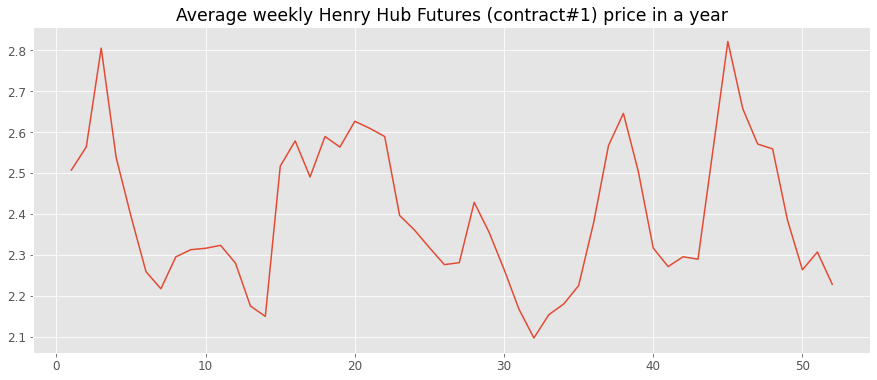

The plot reveals that, the average weekly Henry Hub Futures (Contract#1) price in a year illustrates mainly downward curve.


In [0]:
fig = plt.figure(figsize=(15,6))
plt.plot(NG1[NG1.year >= 2019].groupby('week_no')['Open'].mean().head(52))
plt.title('Average weekly Henry Hub Futures (contract#1) price in a year')
plt.show()
print ('\033[4mThe plot reveals that, the average weekly Henry Hub Futures (Contract#1) price in a year illustrates mainly downward curve.\033[0m')


### ***Average weekly prices***

In [0]:
# Average Weekly Gas Prices Pivot Table
print('\033[4mAverage Weekly Gas Prices Pivot Table\033[0m')
print('\033[4mPrint last 5 rows\033[0m')
pivot_ng = NG1.pivot_table(values = 'Last', columns = ['year'], aggfunc= np.mean,index = ['week_no'])
print(round(pivot_ng.tail(),2)) # last 5 rows
print('\n')

Average Weekly Gas Prices Pivot Table
Print last 5 rows


<IPython.core.display.Javascript object>

year        2000      2001    2002    2003    2004      2005     2006     2007     2008     2009     2010    2011     2012     2013    2014  \
week_no                                                                                                                                       
49       8.05180  2.564200  4.3266  5.8180  7.2954  14.03100  7.69000  7.20780  6.22680  4.63700  4.46780  3.4286  3.60940  4.03400  3.8252   
50       8.18080  2.774200  4.8154  6.8342  6.7912  14.46240  7.49880  7.14860  5.58340  5.08880  4.20220  3.1846  3.38300  4.31320  3.6764   
51       9.27280  2.708000  5.2178  6.9596  7.2384  13.52000  6.87240  7.13640  5.57940  5.57340  4.13275  3.1324  3.40180  4.33900  3.6518   
52       9.70525  2.746667  5.0530  6.2820  6.8240  11.22525  5.85775  7.15725  5.69175  5.71200  4.27160  3.0530  3.39025  4.42975  3.0715   
53           NaN       NaN     NaN     NaN  6.2310       NaN      NaN      NaN      NaN  5.77125      NaN     NaN      NaN      NaN     NaN   

### ***AVerage monthly prices***

In [0]:
# Average Monthly Gas Prices & Percent Changes
print('\033[4mAverage Monthly Gas Prices\033[0m')
monthly = NG1.pivot_table(values= 'Last', columns = ['year'],aggfunc = np.mean, index = ['month_no'])
print(round(monthly,2)) 
print('\n')

monthly.loc[0] = monthly.loc[12,:].shift(1)
monthly.fillna(method='ffill', inplace=True) # filling nan values with previous data
monthly = monthly.sort_index()
print(round(monthly,2))
print('\n')



Average Monthly Gas Prices


<IPython.core.display.Javascript object>

year          2000      2001      2002      2003      2004       2005      2006      2007       2008      2009      2010      2011      2012  \
month_no                                                                                                                                       
1         2.385368  7.825905  2.190571  5.381429  6.278895   6.186250  9.135950  6.684591   7.991476  5.071000  5.596778  4.498300  2.707800   
2         2.614250  5.680316  2.270211  6.657579  5.363000   6.203105  7.520632  7.563800   8.642250  4.389500  5.238222  4.035526  2.525950   
3         2.828261  5.197909  3.013800  5.786286  5.542522   7.042727  6.979348  7.227318   9.638579  4.002136  4.300000  4.060818  2.296857   
4         3.028842  5.189500  3.437955  5.358667  5.765952   7.150524  7.479400  7.610450  10.288091  3.561381  4.083619  4.280263  2.067143   
5         3.596409  4.244545  3.563591  5.926667  6.398650   6.486143  6.372818  7.792391  11.422650  3.932350  4.154050  4.336143  2.49

### ***Monthly volatility***

In [0]:
print('\033[4mAverage monthly gas prices % change\033[0m')
monthly_change = monthly.pct_change()
# dropping the 1st row
monthly_change = monthly_change.drop(monthly_change.index[0])
print(round(monthly_change,2))
 

Average monthly gas prices % change
year          2000      2001      2002      2003      2004      2005      2006      2007      2008      2009      2010      2011      2012  \
month_no                                                                                                                                     
1        -0.724268 -0.095381 -0.184576  0.112303 -0.029351 -0.093988 -0.319485 -0.059561  0.113205 -0.123849  0.047185  0.050558 -0.165877   
2         0.095952 -0.274165  0.036355  0.237140 -0.145869  0.002725 -0.176809  0.131528  0.081433 -0.134392 -0.064065 -0.102877 -0.067158   
3         0.081863 -0.084926  0.327542 -0.130872  0.033474  0.135355 -0.071973 -0.044486  0.115286 -0.088248 -0.179111  0.006267 -0.090696   
4         0.070920 -0.001618  0.140737 -0.073902  0.040312  0.015306  0.071647  0.053012  0.067387 -0.110130 -0.050321  0.054040 -0.100012   
5         0.187387 -0.182090  0.036544  0.105997  0.109730 -0.092914 -0.147951  0.023907  0.110279  0.104164  0.

### ***Raise vs Decline***

In [0]:
print('\033[4mProbabilities of Monthly Gas Price Decline vs Raise\033[0m')
print('\033[4mProbability of gas price decline starts to increase by the summer months. It seems that fluctuations in gas price in the initial months of the year is rather high.\033[0m')
monthly_change['raise'] = monthly_change[(monthly_change.iloc
                                                              [:,:]>0)].count(axis=1)/(2020-2000)
monthly_change['decline'] = monthly_change[(monthly_change.iloc
                                                              [:,:]<0)].count(axis=1)/(2020-2000)   
print(monthly_change[['raise', 'decline']])

Probabilities of Monthly Gas Price Decline vs Raise
Probability of gas price decline starts to increase by the summer months. It seems that fluctuations in gas price in the initial months of the year is rather high.
year      raise  decline
month_no                
1          0.35     0.70
2          0.35     0.70
3          0.50     0.55
4          0.65     0.40
5          0.70     0.30
6          0.55     0.45
7          0.20     0.80
8          0.25     0.75
9          0.50     0.50
10         0.60     0.40
11         0.55     0.45
12         0.40     0.60


# **Dash-Board**

### ***Experimentation lab !!!***

In [0]:
!pip install dash
import dash
import dash_core_components as dcc
import dash_html_components as html

import plotly.graph_objs as go
from dash.dependencies import Input, Output

app = dash.Dash()
server = app.server

### ***Section 1***

- We set-up our App and its layout using the code shown below. 

- The layout is stored in app.layout, and all the desired HTML components such as Div, H1, H2, P, etc have been added using the dash_html_components (html) library. 

- Finally, we can add interactive components to our dashboard (eg. tabs, dropdowns, radio buttons) using the dash_core_components (dcc) library.

- We have divided this Dashboard into two tabs. 
  - The first one, will be analysed the Gas Prices dataset and 
  - the second one the Henry Hub Spot dataset. 
  
The layout of the first tab is subsequently divided into other two parts each of them formed by an H1 title, 
- a dropdown menu with four different options and
- a time-series graph. 

The second tab is instead formed by just an H1 title, a dropdown menu with Henry Shub Spot price.

In [0]:
app.layout = html.Div([

    # Setting the main title of the Dashboard

    html.H1("Natural Gas Data Analysis", style={"textAlign": "center"}),

    # Dividing the dashboard in tabs

    dcc.Tabs(id="tabs", children=[

        # Defining the layout of the first Tab

        dcc.Tab(label='Natural Gas Contract Prices', 
                children=[html.Div([html.H1("Daily Price (USD / Mbtu)", 
                                            style={'textAlign': 'center'}),

                # Adding the first dropdown menu and the subsequent time-series graph

                dcc.Dropdown(id='my-dropdown1',
                             options=[{'label': 'Natural Gas', 'value': 'Daily Price'},
                                      {'label': 'Volume','value': 'Volume'}],
                             multi=True, value=['NG'],
                             style={"display": "block", 
                                    "margin-left": "auto",
                                    "margin-right": "auto", 
                                    "width": "60%"}),
                            
                          
                dcc.Graph(id='dailyprices')],
                className="container"),

        ]),


        # Defining the layout of the second tab

        dcc.Tab(label='Henry Hub Spot Price', 
                children=[html.H1("Daily Price (USD / Mbtu", 
                                  style={"textAlign": "center"}),

            # Adding a dropdown menu and the subsequent graph

            html.Div([html.Div([dcc.Dropdown(id='my-dropdown2',
                                             options=[{'label': 'Henry Hub', 'value': 'hh_spot'}],
                                             multi=True, value=['hh_spot'],
                                             style={"display": "block", 
                                                    "margin-left": "auto",
                                                    "margin-right": "auto", 
                                                    "width": "60%"}),

                    dcc.Graph(id='my-graph2'),

        ])

    ])

])

### ***Section 2***

Once Dashboard layout defined, we can then go on and design the graphs and their interaction with the dropdown menus. 

The graphs designed creating functions and the dropdown menus designed using callbacks.

The code below can be divided in : 
- Open Gas Prices Time Series graph
- Close Gas Prices Time Series graph
- a High Gas Prices Time Series graph,
- a Low Gas Prices Time Series graph,
- Adj close Prices Time Series graph, 
- a Market Volume Time Series graph and 
- Henry Hub Spot price.

In each of the sections, the callbacks (@app.callback) are used to take the selected values from the dropdowns, send them as input to the graph function and then take the variable returned by the function to pass it to the graph declared in the layout. These callbacks will automatically get called every-time the values in the dropdowns changes. The callbacks can automatically identify which of the different dropdowns available on the Dashboard changed value and which graph to subsequently update thanks to the unique id values set before in the Dashboard Layout.

Each of the three functions shown below use Plotly syntax to create the graphs. 

In [0]:
@app.callback(Output('highlow', 'figure'),[Input('my-dropdown', 'value')])

def update_graph(selected_dropdown):

    dropdown = {"HH": "Henry Hub","NG": "Natural Gas",}
    trace1 = []
    trace2 = []

    for stock in selected_dropdown:

        trace1.append(

          go.Scatter(x=NG[NG["Stock"] == stock]["Date"],
                     y=NG[NG["Stock"] == stock]["High"],
                     mode='lines', opacity=0.7, 
                     name=f'High {dropdown[stock]}',textposition='bottom center'))

        trace2.append(

          go.Scatter(x=NG[NG["Stock"] == stock]["Date"],
                     y=NG[NG["Stock"] == stock]["Low"],
                     mode='lines', opacity=0.6,
                     name=f'Low {dropdown[stock]}',textposition='bottom center'))

    traces = [trace1, trace2]

    data = [val for sublist in traces for val in sublist]

    figure = {'data': data,
              'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1', '#FF7400', '#FFF400', '#FF0056'],
            height=600,
            title= f"High & Low Prices for {','.join(str(dropdown[i]) for i in selected_dropdown)} Over Time",

            xaxis={"title":"Date",
                   'rangeselector': {'buttons': list([{'count': 1, 
                                                       'label': '1M', 
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'count': 6, 
                                                       'label': '6M', 
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'step': 'all'}])},'rangeslider': {'visible': True}, 'type': 'date'},

             yaxis={"title":"Price (USD)"})}

    return figure



@app.callback(Output('volume', 'figure'),
              [Input('my-dropdown2', 'value')])

def update_graph(selected_dropdown_value):

    dropdown = {"HH": "Henry Hub","NG": "Natural Gas",}

    trace1 = []

    for stock in selected_dropdown_value:

        trace1.append(

          go.Scatter(x=NG[NG["Stock"] == stock]["Date"],
                     y=NG[NG["Stock"] == stock]["Volume"],
                     mode='lines', opacity=0.7,
                     name=f'Volume {dropdown[stock]}', textposition='bottom center'))

    traces = [trace1]

    data = [val for sublist in traces for val in sublist]

    figure = {'data': data, 
              'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1', '#FF7400', '#FFF400', '#FF0056'],

            height=600,
            title=f"Market Volume for {', '.join(str(dropdown[i]) for i in selected_dropdown_value)} Over Time",
            xaxis={"title":"Date",
                   'rangeselector': {'buttons': list([{'count': 1, 
                                                       'label': '1M', 
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'count': 6, 
                                                       'label': '6M',
                                                       'step': 'month',
                                                       'stepmode': 'backward'},
                                                      {'step': 'all'}])},

                   'rangeslider': {'visible': True}, 'type': 'date'},

             yaxis={"title":"Transactions Volume"})}

    return figure


Finally, we can start a local server and make our application run by using the following code.

In [0]:
if __name__ == '__main__':
    app.run_server(debug=True)